# 0.0 IMPORTS

In [1]:
import pandas as pd
import math
import numpy as np

import inflection
import datetime
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import xgboost as xgb

import random
import warnings
import requests

## 0.1. Helper functions
In this section, we define some functions that will help us along the project.

In [97]:
# sets seaborn style
sns.set_style("darkgrid")
sns.set_palette("muted")

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = None

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

# ignores warnings
warnings.filterwarnings('ignore')

# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

# calculates the errors
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

# mean percentage error (MPE)
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# makes de cross validation for a given model
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    # creates empty lists to store the metrics
    mae_list = []
    mape_list = []
    rmse_list = []

    # runs the KFold
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # gets the final date and subtracts 6 weeks
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 7 * 6)

        # gets the final date
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 7 * 6)

        # filters dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m_regression = model.fit(xtraining, ytraining)

        # prediction
        yhat = m_regression.predict(xvalidation)

        # performance
        regression_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # stores the performance of each KFold iteration
        mae_list.append(regression_result['MAE'])
        mape_list.append(regression_result['MAPE'])
        rmse_list.append(regression_result['RMSE'])

    # calculates the mean from the errors : the real metric for the algorithm
    # and creates a DataFrame to organize the data
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                       index=[0])

Other optional settings that could be applied.

```python
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figzise'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
```

## 0.2 Loading data
In this section, we import the data.

In [3]:
# loads train dataset
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)

# loads store dataset
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge the two datasets into one
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [ ]:
# checks the operations
df_raw.sample()

# 1.0 DATA DESCRIPTION

Let's take a look at data field descriptions from Kaggle.

https://www.kaggle.com/c/rossmann-store-sales/data

**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### 1.0.1 Project initial checkpoint

In [ ]:
# checks the dataset
df_raw

In [4]:
# makes a copy from original DataFrame, so we can separate the dataset manipulation by section
df1 = df_raw.copy()

## 1.1. Renaming columns
Rename columns to make easier to understand and work with them.

In [ ]:
# checks the columns in out dataset
df1.columns

In [5]:
# stores the old column names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# snake_case
snakecase = lambda x: inflection.underscore(x)

# creates new columns from old columns in snakecase 
cols_new = list(map(snakecase, cols_old))

# renames the old columns
df1.columns = cols_new

In [ ]:
# checks the operations
df1.columns

## 1.2.  Checking data dimensions
Verifies the number of rows and columns in the dataset.

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3.  Checking data types
Verifies the dataset data types.

In [ ]:
df1.dtypes

In [7]:
# transforms 'date' column to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Checking NaN values
Verifies the presence of missing values.

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We noticed that we have a lot of missing data. We can chosse one of the following three paths:

**1) Exclude all lines that have missing data**, but we may lose important information that the ML algorithm may need and negatively impact the forecasting.

**2) Use ML techniques to fill in the missing data** and predict what value would replace the `NaN`. This method is good when we don't have business information available.

**3) Really understand the business.** Understand the business rules and fill in the missing data with relevant information.

## 1.5.  Filling out the NaN values
We chose the method 3 (understand the business).

### 1.5.1 Filling the competition data

In [ ]:
# checks the maximum distance to the nearest competitor
df1['competition_distance'].max()

In [9]:
# competition_distance
# let's assume that the distance from competitors is so long that there are no competitors
# applies for each column record: competition_distance
#     assign 200000.0 if record == NaN ; assign its current value if record != NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# let's assume that the opening date is the store sales date: date
# axis=1 -> apply in the row along the columns, because we have more than one column in the expression
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [ ]:
# checks the operations
df1.sample(5).T

### 1.5.2 Filling the promotion data

In [10]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [11]:
# promo_interval

# creates a dictionary that will help in mapping
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# fills in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

# creates the 'month_map' column as the month mapping of the 'date' column
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [ ]:
# checks the operations
df1.sample(5).T

In [12]:
# make a split in 'promo_interval' column and creates a list containing the values
# check if the value of 'month_map' is within that list
# creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [ ]:
# checks the operations
df1.sample(5).T

### 1.5.4 Checking the final values

In [13]:
# checks the operations
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6.  Changing data types

In [14]:
# checks columns data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

We notice that the following columns are `float64`:
- `competition_open_since_month`
- `competition_open_since_year`
- `promo2_since_week` 
- `promo2_since_year` 

However, they are actually `int` values as they represent months and years which are discrete values. Thus, we can do:

In [15]:
# transforms competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# transforms promotion data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [16]:
# checks the operations
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

It is through the descriptive statistics that we are able to get a notion from the business. It helps detect some errors.

Thereare two big metrics that we have to keep our eyes on: **data distribution and central tendency**.

**Central tendency:** summary statistics like median, mean, max, min, quantiles.

**Data distribution:** we need to know how the data is distributed around the median and mean.

Other important statistics: **skewness and kurtosis**.

Also, check how variabless behave and look for negative values that shouldn't be.

In [17]:
# creates a dataset for numerical attributes
num_attributes = df1.select_dtypes(include=['int64','float64'])

# creates a dataset for categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [ ]:
# checks the operation
num_attributes.sample(2)

In [ ]:
# checks the operation
cat_attributes.sample(2)

### 1.7.1 Numerical attributes

In [18]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [19]:
# checking the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Plotting distribution for `sales`

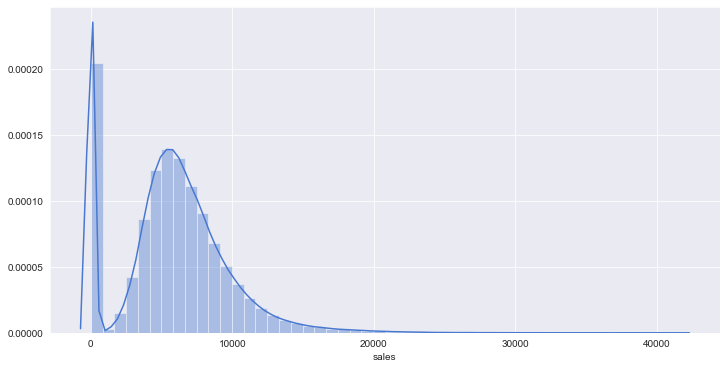

In [20]:
# plots distribution
ax = sns.distplot(df1['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

#### Plotting distribution for `competition_distance`

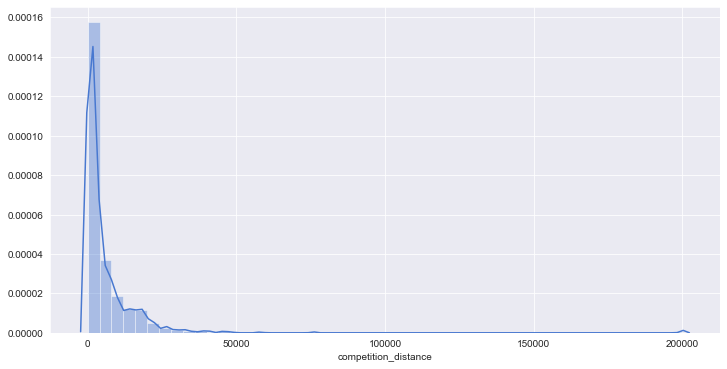

In [21]:
# plots distribution
ax = sns.distplot(df1['competition_distance'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

#### Using pandas.describe

In [ ]:
num_attributes.describe().T

### 1.7.1 Categorical attributes

In [22]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

#### Plotting boxplots for `state_holiday`, `store_type` and `assortment` in relation to `sales`

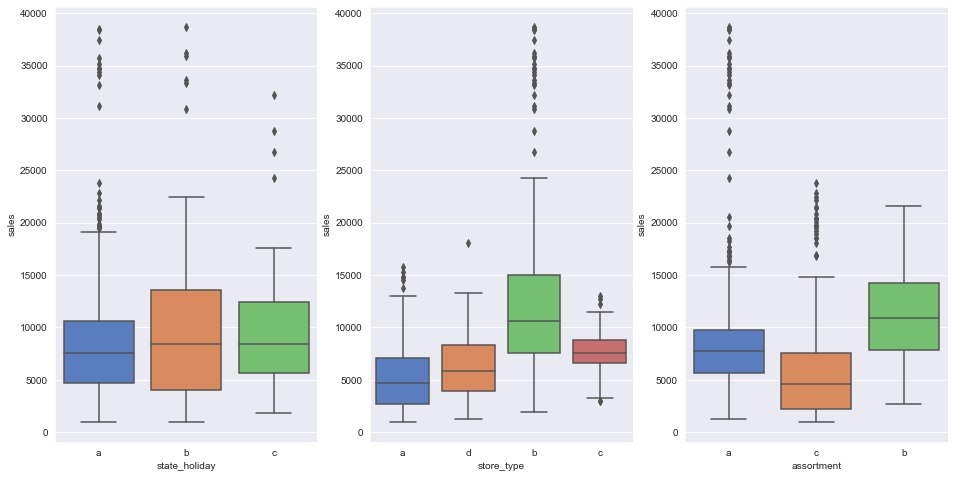

In [23]:
# filters the data that we want to display
# as we don't want to see all the days on which the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1)

# displays plot
plt.show()

# 2.0 FEATURE ENGINEERING

### 2.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df1`. So we don't have to run everything from the start. We can start from here.

In [24]:
# copies df1 to df2
df2 = df1.copy()

## 2.1 Hypothesis Mindmap
In real life, we draw the mindmap with the stakeholders in a brainstorm-like meeting.

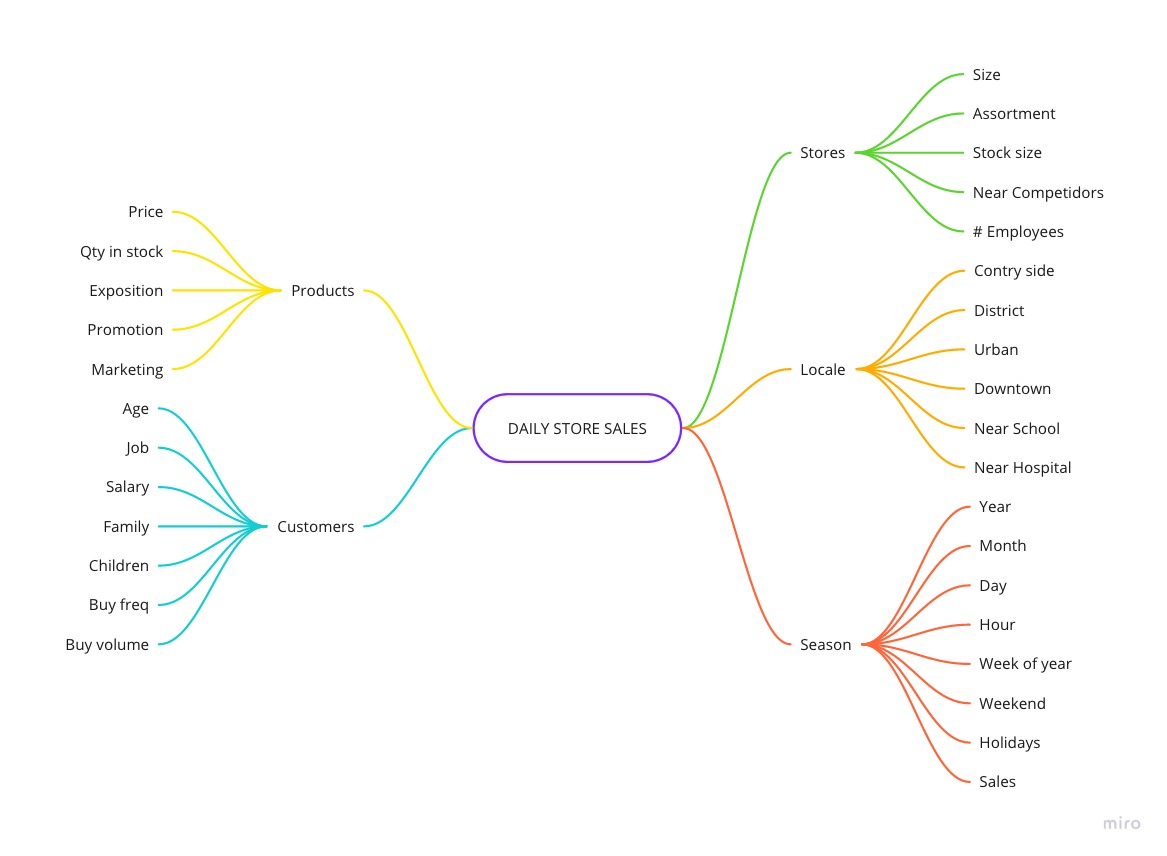

In [25]:
# displays the mindmap
Image('../img/hypothesis_map.png')

## 2.2 Creating hypothesis

Creating hypothesis for each variable that you believe that impact in the phenomenon that we are studying, in this case, **Daily Store Sales**, and relate each variable's attributes with the phenomenon.

In real life, we outline the hypothesis in a brainstorm-like meeting with the stakeholders.

### 2.2.1 Store Hypothesis

**1.** Stores with higher number of employees should have higher sales.

**2.** Stores with higher stock should should have higher sales.

**3.** Stores with higher size should should have higher sales.

**4.** Stores with lesser size should have lesser sales.

**5.** Stores with higher assortment should should have higher sales.

**6.** Stores with nearer competitors should have lesser sales.

**7.** Stores with longer competitors should have higher sales.

### 2.2.2 Product Hypothesis

**1.** Stores with higher investments in marketing should have higher sales.

**2.** Stores with higher product exposure should should have higher sales.

**3.** Stores with lesser product prices should should have higher sales.

**4.** Stores with higher discount values should should have higher sales.

**5.** Stores with lesser product prices for longer period of time should should have higher sales.

**6.** Stores with longer period of time in promotion should have higher sales.

**7.** Stores with higher consecutive promotions should have higher sales.

### 2.2.3 Season Hypothesis

**1.** Stores that open on Xmas should have higher sales. 

**2.** Stores should have higher sales along the year.

**3.** Stores should have higher sales on the second semester of the year.

**4.** Stores should have higher sales after the 10th day of the month.

**5.** Stores should have lesser sales on weekends.

**6.** Stores should have lesser sales during school holidays.

## 2.3 Prioritized hypothesis list
We prioritize the hypothesis based on: whether we have or not the data at hand.

There may be data that we don't have it at hand and we need to spend some time on accessing it, collecting it, cleaning it and analyzing it.

**Store**

**1.** Stores with higher assortment should have higher sales.

**2.** Stores with nearer competitors should have lesser sales.

**3.** Stores with longer competitors should have higher sales.

<br>

**Product**

**4.** Stores with lesser product prices for longer period of time should have higher sales.

**5.** Stores with longer period of time in promotion should have higher sales.

**6.** Stores with higher consecutive promotions should have higher sales.

<br>

**Season**

**7.** Stores that open on Xmas should have higher sales. 

**8.** Stores should have higher sales along the years.

**9.** Stores should have higher sales on the second semester of the year.

**10.** Stores should have higher sales after the 10th day of the month.

**11.** Stores should have lesser sales on weekends.

**12.** Stores should have lesser sales during school holidays.

## 2.4 Feature engineering - de facto
In this section, we are going to create some variables (columns) in our dataset to make easier do explore the dataset in the EDA phase.

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [ ]:
# checks the operations
df2.head().T

In [27]:
# competition since

# creates a new datetime column 'competition_since' which is a compound of two columns
# we are specifying that it will always have the 1st day of the month
df2['competition_since'] = df2.apply(lambda x: 
                                     datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), 
                                     axis=1)

In [ ]:
# checks the operations
df2.head().T

In [28]:
# How many months has passed since the competition store opened?
# gets the difference between columns and divides it by 30 to make the monthly granularity
#     then we get the days as int type
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

In [ ]:
# checks the operations
df2.head().T

In [29]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

# converts values from 'promo_since' to datetime considering 7 days
df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                         datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# How many weeks has passed since the promotion started?
# OR for how long (in weeks) the promotion is active?
# gets the difference between columns and divides it by 7 to make the weekly granularity
#     then we get the days as int type
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

In [ ]:
# checks the operations
df2.head().T

In [30]:
# assortment
# replaces the values to make easier to understand them
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# replaces the values to make easier to understand them
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [31]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

### 3.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df2`. So we don't have to run everything from the start. We can start from here.

In [32]:
# copies df2 to df3
df3 = df2.copy()

In [33]:
# checks the dataset
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Row filtering
We're going to filter the rows first, because the performance is better when fltering the columns later. There are less data to process.

As it makes no sense to get data from closed stores (`open = 0`), we'll consider only the rows where `open = 1` which is the same as saying `'open' != 0`.

As closed stores have 0 sales, we'll consider only the sales from open stores (`open = 1`), that is, `'sales' > 0`.

In [34]:
# gets only the rows for open stores and sales above zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column filtering

We don't have the number of `customers` at the moment of the prediction. We would need other ML model to predict it and use it here. The scope of this project will not consider the customers, so we'll classify it as a business restriction.

In the previous step, as we filtered only the rows where `open = 1`, it makes no sense to keep the column `open` because it has only values equal to `1`.

Also, the columns `promo_interval` and `month_map` were only used to derive other columns. Thus, we don't need them anymore.

In [35]:
# drops the columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drops the columns
df3 = df3.drop(cols_drop, axis=1)

In [36]:
# checks the operation
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

### 4.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df3`. So we don't have to run everything from the start. We can start from here.

In [37]:
# copies df3 to df4
df4 = df3.copy()

In [38]:
# checks the dataset
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate analysis

### 4.1.1 Target variable

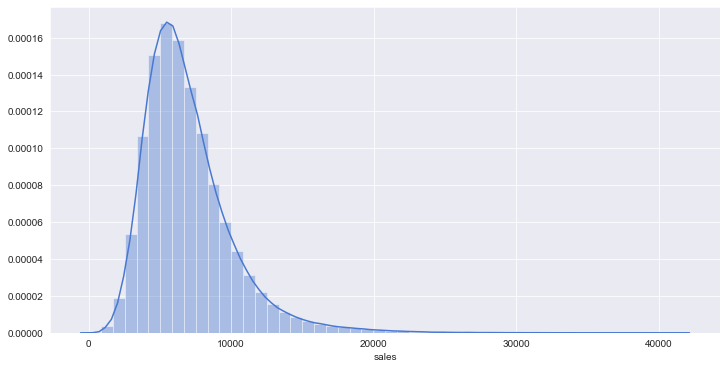

In [39]:
# plots distribution
ax = sns.distplot(df4['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

As we can observe, the distribution is **moderately skewed** (`skewness = 0.641460`) and presents a **positive kurtosis** (`1.778375`) which means that we have some possible outliers in our dataset. Thus, the distribution **does not follow a normal distribution**.

As the ML algorithms requires our data to have **independent variables and normal distribution**, we can apply some techniques to do the variable transformation.

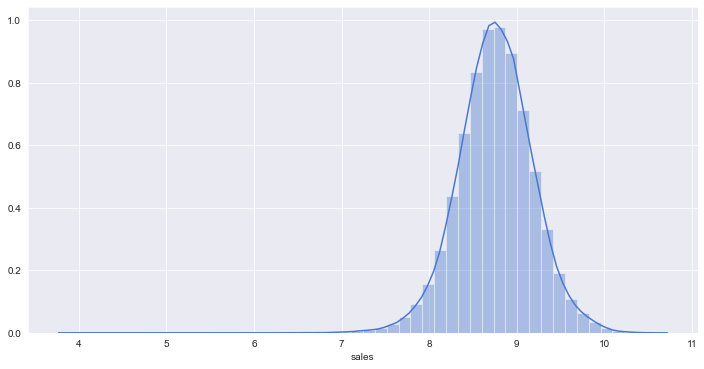

In [40]:
# distribution plotting for 'sales'
# applies log(x + 1) to 'sales'
ax = sns.distplot(np.log1p(df4['sales']))

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

### 4.1.2 Numerical variable (TO DO = Seaborn multi var hist plot)

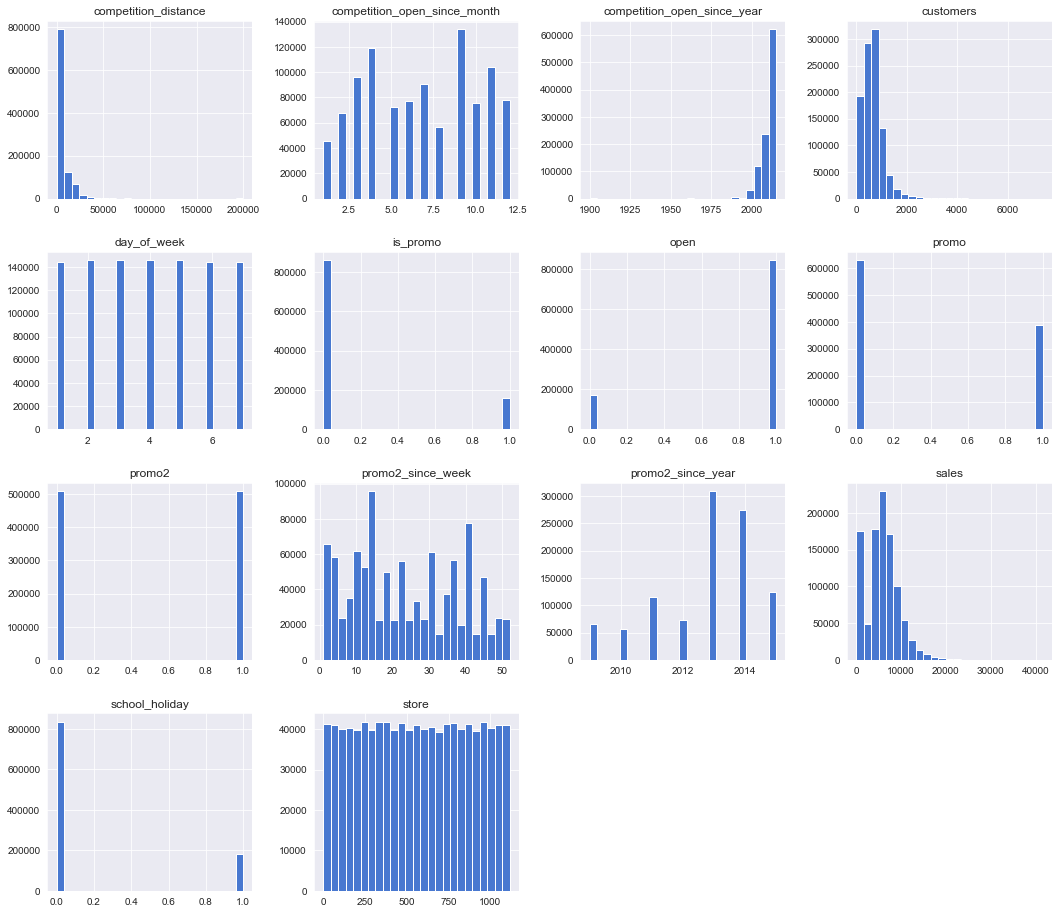

In [41]:
# sets the figure size
fig = plt.figure(figsize = (18,16))

# sets axes
ax = fig.gca()

# plots histograms
num_attributes.hist(ax=ax, bins=25);

Analyzing the histograms, for:
- `competition_distance`: we have more competitors that are near the stores, as they gather in the range from 0 to near 50000. 
- `competition_open_since_month`: we have a somewhat seasonal opening of competitor stores.
- `day_of_week`: we have a distribution that is nearly uniform, this tells us that the sales nearly don't vary according to the day of the week. Thus, this variable, alone, doesn't have much relevance to the model.
- `is_promo`: we have higher sales when there is no promotion (`is_promo = 0`) than when we have (`is_promo = 1`).
- `competition_open_since_year`: we can clearly see that the opening of new competitors stores had a peak near 2015.
- `customers`: as this variable describes the number of customers in a given day, we have a high concentration at the beginning then an abrupt decrease on this number. This behavior might be due to the peaked increase on the opening of new competitors stores, as the customers start to be distributed among the stores.
- `day_of_week`: as the stores are open 7 days per week, we se that there is a distribution that is nearly uniform.
- `is_promo`: we can see that there are many more stores that weren't in promotion (`is_promo = 0`) than in promotion (`is_promo = 1`).
- `open`: we can see that there are many more stores that were open (`open = 1`) than closed (`open = 0`).
- `promo`: we can see that there are many more stores that weren't in regular promotion (`promo = 0`) than those who were (`promo = 1`).
- `promo2`: we can see that there were almost equally number of stores in consecutive promotion. This might have been an experiment from Rossmann to check whether being on a consecutive promotion would impact the number of sales.
- `promo2_since_week`: we can see there is no clear pattern, there are some peaks, but we'll need to dig deeper on this topic.
- `promo2_since_year`: we can see that there were many more stores in consecutive promotion around 2014.
- `sales`: we can see that there were many more sales ranging from $0 to nearly $10,000.
- `school_holiday`: we can see that there are many more stores that weren't affected by the closure of public schools (`school_holiday = 0`) than those who were (`school_holiday = 1`).
- `store`: as this variable describes the unique Id for each store, there is no real information that we can extract from this one.


### 4.1.3 Categorical variable

In [42]:
# checks the categorical variables
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [43]:
# checks the unique values for 'state_holiday' we have in the dataset
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [44]:
# checks unique values for 'state_holiday'
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

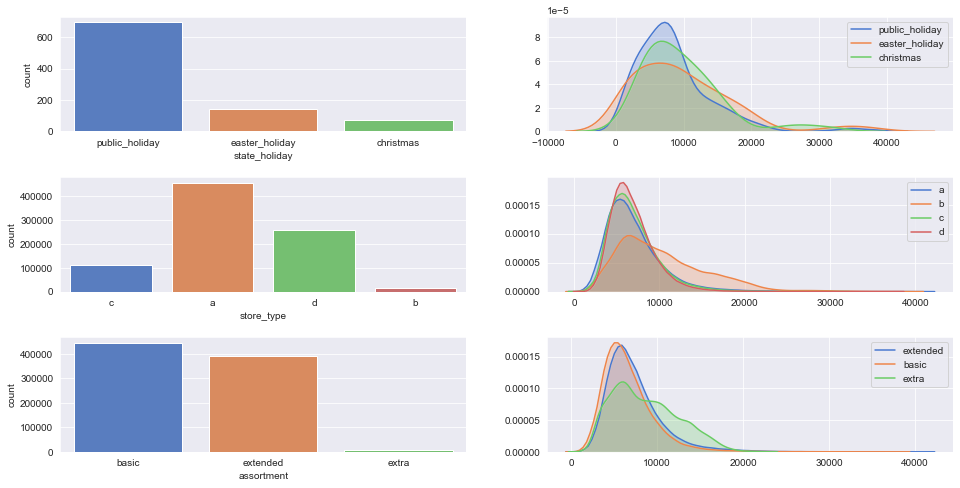

In [45]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# state_holiday
plt.subplot(3,2,1)
df_no_regular_day = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df_no_regular_day['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# display plots
plt.show()

## 4.2 Bivariate analysis

In [ ]:
# checks the dataset
df4

### H1. Stores with higher assortment should have higher sales.

In [46]:
# gets total sales for each 'assortment' type
df_total_sales_by_assortment = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
df_total_sales_by_assortment

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


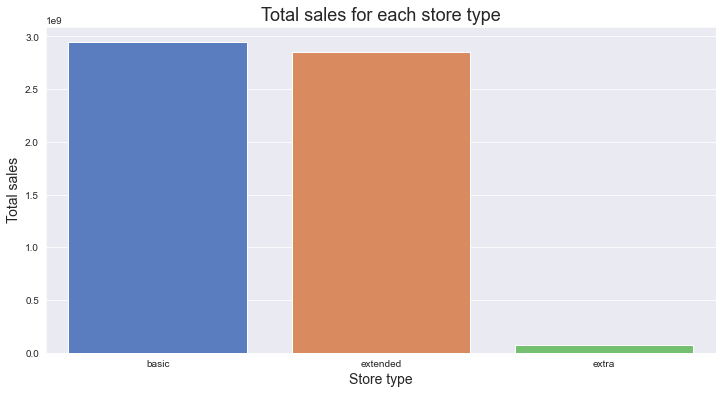

In [47]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

ax = sns.barplot(x='assortment', y='sales', data=df_total_sales_by_assortment)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each store type", "Store type", "Total sales")

# displays the plot
plt.show()

We are assuming that stores that have higher assortment are classified as type `extra`. Thus, observing the barplot, we can verify that stores with **lesser assortment (`basic`) have higher sales**.

> #### In other words, **stores with higher assortment have lesser sales**.

However, we need to check if in the past, stores with higher assortment had higher sales.

In [48]:
# checks each assortment sales 
df_total_sales_by_year_week_assortment = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
df_total_sales_by_year_week_assortment

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


In [49]:
# creates a pivot table
df_total_sales_pivot = df_total_sales_by_year_week_assortment.pivot(index='year_week', columns='assortment', values='sales')
df_total_sales_pivot

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


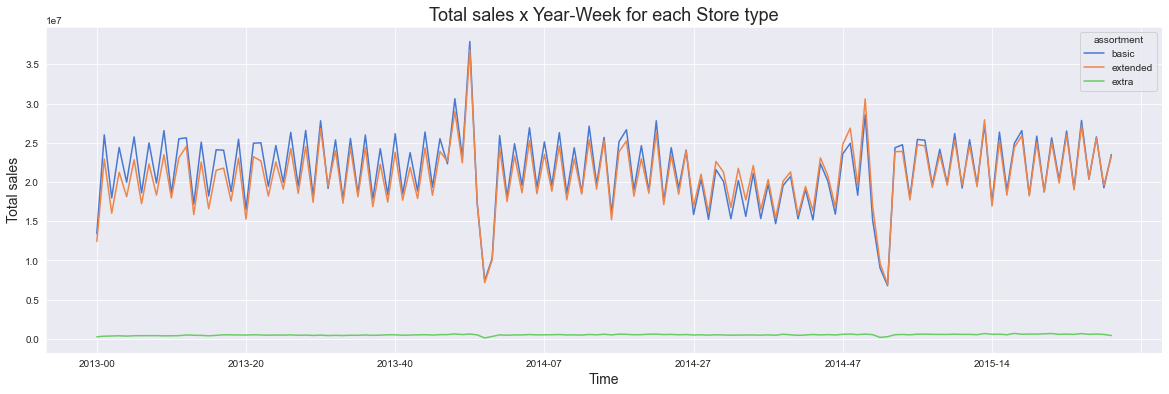

In [50]:
# plots a lineplot for 'aux3'
ax = df_total_sales_pivot.plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year-Week for each Store type", "Time", "Total sales")

# displays the plot
plt.show()

In [ ]:
# filters for only 'extra' type of assortment
df_only_extra = df_total_sales_by_year_week_assortment[df_total_sales_by_year_week_assortment['assortment'] == 'extra']

# plots a lineplot for 'df_only_extra'
ax = df_only_extra.pivot(index='year_week', columns='assortment', values='sales').plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year-Week for Store type 'extra'", "Time", "Total sales")

# displays the plot
plt.show()

Observing the line plots, we can verify that **stores with higher assortment (`extra`) have lesses sales**. 

> #### So, our hypothesis is **FALSE**.

In addition, as the variables have distinct behaviour, it may be interesting to **include them in our ML model**.

### H2. Stores with nearer competitors should have lesser sales.

In [51]:
# checks total sales for each 'competition_distance'
df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
df_total_sales_by_competition_distance

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359
...,...,...
650,46590.0,3554993
651,48330.0,3798660
652,58260.0,5718883
653,75860.0,6896821


In [52]:
# creates bins that range from 0 to 20000 with steps of 1000
bins = list (np.arange(0, 20000, 1000))

# places the data in the bins
df_total_sales_by_competition_distance['competition_distance_binned'] = pd.cut(df_total_sales_by_competition_distance['competition_distance'], bins=bins)

df_total_sales_by_competition_distance.sample(10)

,competition_distance,sales,competition_distance_binned
193,2220.0,3274470,"(2000, 3000]"
215,2530.0,4929786,"(2000, 3000]"
439,8110.0,5732970,"(8000, 9000]"
378,5840.0,4028334,"(5000, 6000]"
456,8780.0,4037973,"(8000, 9000]"
164,1880.0,7974294,"(1000, 2000]"
327,4520.0,15119458,"(4000, 5000]"
319,4370.0,13962462,"(4000, 5000]"
451,8540.0,6397583,"(8000, 9000]"
489,10570.0,4152028,"(10000, 11000]"


In [53]:
# gets the total sales for each bin
df_competition_distance_binned = df_total_sales_by_competition_distance[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
df_competition_distance_binned

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741
5,"(5000, 6000]",218735915
6,"(6000, 7000]",168769215
7,"(7000, 8000]",133211838
8,"(8000, 9000]",180027950
9,"(9000, 10000]",121250715


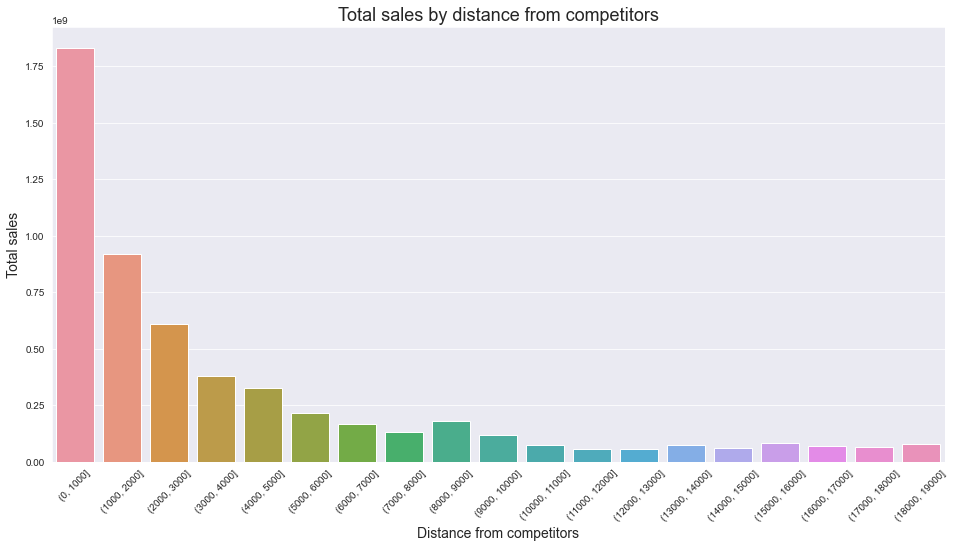

In [54]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='competition_distance_binned', y='sales', data=df_competition_distance_binned)

# rotates xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

As we can observe from the bar plot, **stores with nearer competitors have higher sales**. 

> #### So, our hypothesis is **FALSE**.

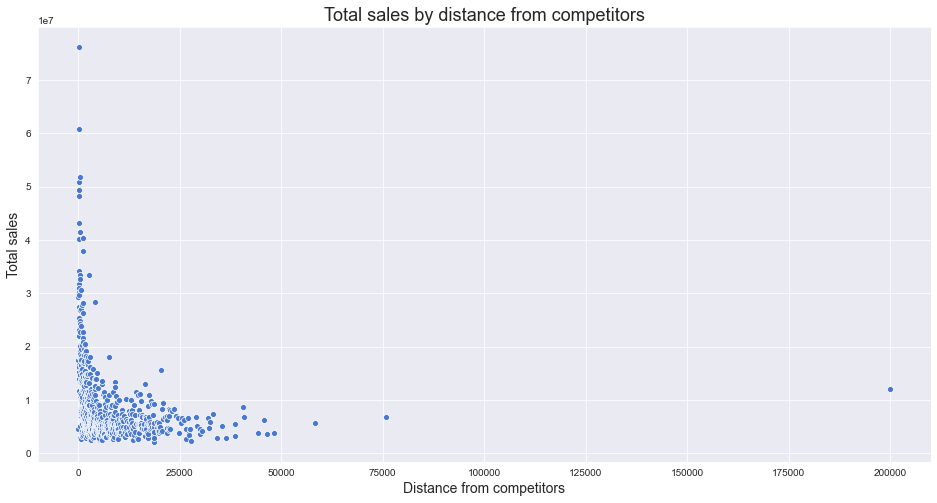

In [55]:
# checks total sales for each 'competition_distance'
df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot for sales in relation to competition_distance
ax = sns.scatterplot(x='competition_distance', y='sales', data=df_total_sales_by_competition_distance)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

We can observe from the scatter plot that we have a higher concentration of sales as we decrease the competition distance, which also makes our hypothesis **FALSE**.

#### Organizing the plots in a single grid

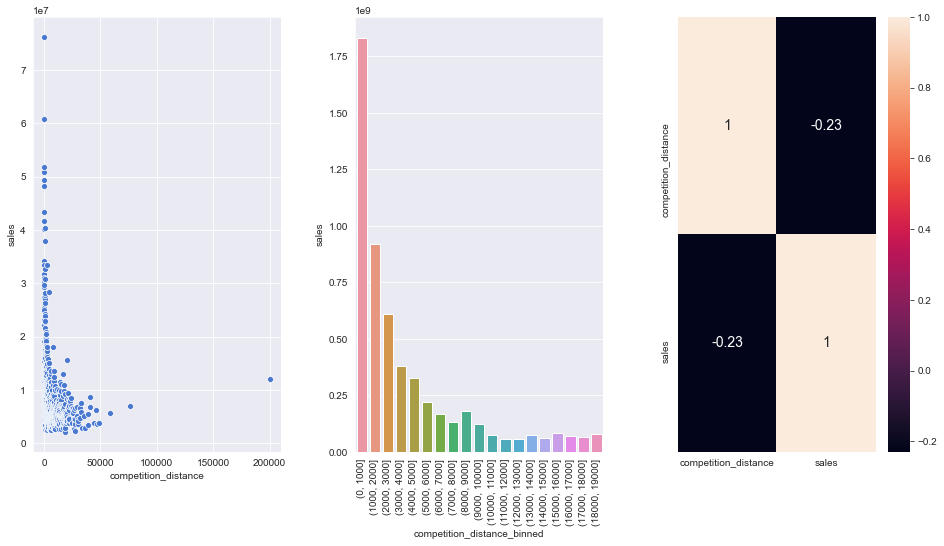

In [56]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.scatterplot(x='competition_distance', y='sales', data=df_total_sales_by_competition_distance)


# plots a bar plot
plt.subplot(1, 3, 2)
ax = sns.barplot(x='competition_distance_binned', y='sales', data=df_competition_distance_binned)

# rotates xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_competition_distance.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.3)

# displays the plots
plt.show()

**Correlations**

As observed in the results, the Pearson's correlation coefficient between `competition_distance` and `sales` is `-0.23` which tells us that is a **weak negative correlation**. Despite the weakness, we may include the `competition_distance` because it has a somewhat influence on the target variable (`sales`).

### H3. Stores with longer competitors should have higher sales.

We want to know how do our `sales` behave in relation to how long a competitor store has opened.

In [57]:
# gets all sales by months since the a competition store opened
df_total_sales_by_comp_time_month = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

# gets only the 120 months AND opened in the same month of the sale
df_total_sales_120_months = df_total_sales_by_comp_time_month[(df_total_sales_by_comp_time_month['competition_time_month'] < 120) & (df_total_sales_by_comp_time_month['competition_time_month'] != 0)]

df_total_sales_120_months

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
...,...,...
147,115,15655375
148,116,15784105
149,117,15658505
150,118,14428150


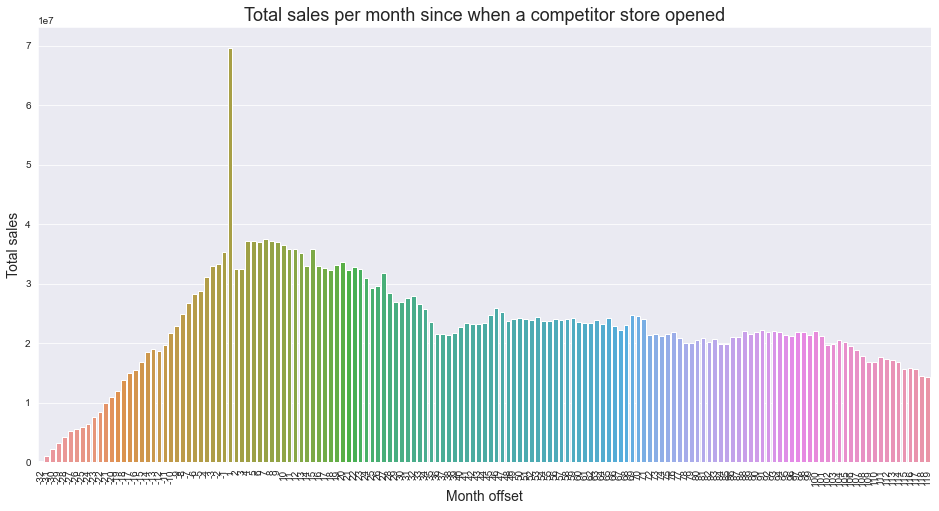

In [58]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# rotates the xticks
plt.xticks(rotation=90)

# sets the title and axis labels
set_plots_features(ax, "Total sales per month since when a competitor store opened", "Month offset", "Total sales")

# displays plot
plt.show()

- **Negative offset values:** we already started selling and we know when a competitor store will still open in x months. 
- **Positive offset values:** competitor store has already opened and we started selling.

As values gets near zero the higher are the sales. **The earlier the competition is, the higher the sales are.** 

> #### Thus, our hypothesis is **FALSE**.

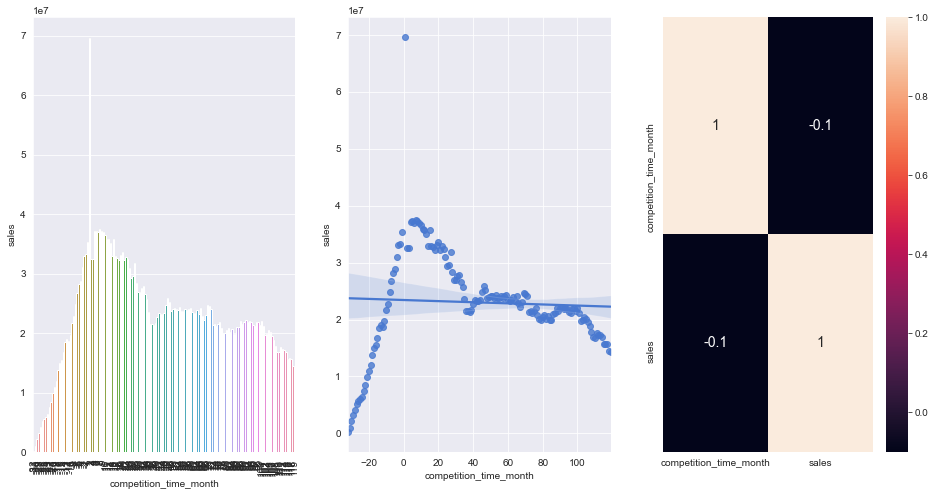

In [59]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# rotates the xticks
plt.xticks(rotation=90)

# plots a regplot
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_comp_time_month.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

**Correlations**

As observed in the results, the Pearson's correlation coefficient between `competition_time_month` and `sales` is `-0.1` which tells us that is a **super weak negative correlation**. Despite the weakness, we may include the `competition_time_month` because it has a somewhat influence on the target variable (`sales`). We'll check its relevance later in our project.

### H4. Stores with longer period of time in promotion should have higher sales.

In [60]:
# gets total sales based on how long a promotion was active
df_total_sales_by_promo_week = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
df_total_sales_by_promo_week

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
...,...,...
435,309,360433
436,310,277156
437,311,353546
438,312,268970


- `promotime_week > 0`: sales made inside the **extended** promotion time.
- `promotime_week < 0`: sale made inside the **regular** promotion time.

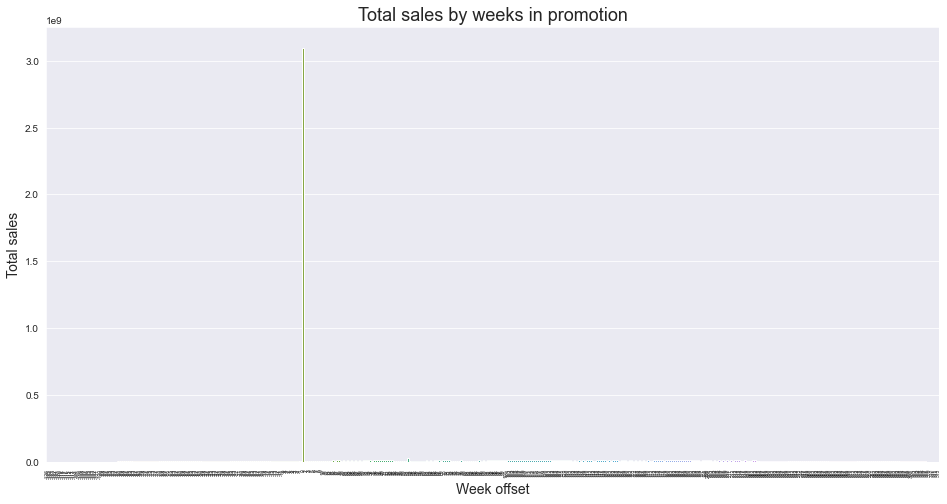

In [61]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_by_promo_week)

# rotates the xticks
plt.xticks(rotation=90, fontsize=5)

# sets the title and axis labels
set_plots_features(ax, "Total sales by weeks in promotion", "Week offset", "Total sales")

# displays the plot
plt.show()

As we observe in the bar plot, we can't see anything because there are loads of data. So, let's divide our data in two periods: **regular promotion and extended promotion**.

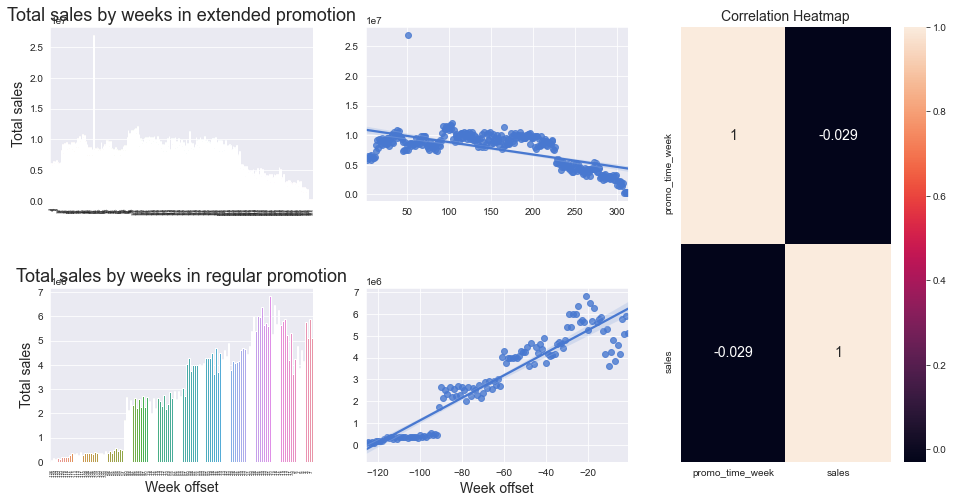

In [62]:
from matplotlib.gridspec import GridSpec

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

grid = GridSpec(2, 3)

# adjusts the space between subplots
plt.subplots_adjust(hspace = 0.5)

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# gets the extended promo data
df_total_sales_extended_promo = df_total_sales_by_promo_week[df_total_sales_by_promo_week['promo_time_week'] > 0] 

# plots a barplot
plt.subplot(grid[0, 0])
ax1 = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_extended_promo);

# sets the title and axis labels
set_plots_features(ax1, "Total sales by weeks in extended promotion", " ", "Total sales")

# rotates the xticks
plt.xticks(rotation=90, fontsize=4)

# plots a regplot
plt.subplot(grid[0, 1])
ax2 = sns.regplot(x='promo_time_week', y='sales', data=df_total_sales_extended_promo);

# sets the title and axis labels
set_plots_features(ax2, " ", " ", " ")


# gets the regular promo data
df_total_sales_regular_promo = df_total_sales_by_promo_week[df_total_sales_by_promo_week['promo_time_week'] < 0]

# plots a barplot
plt.subplot(grid[1, 0])
ax3 = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_regular_promo);

# sets the title and axis labels
set_plots_features(ax3, "Total sales by weeks in regular promotion", "Week offset", "Total sales")

# rotates the xticks
plt.xticks(rotation=90, fontsize=4)


# plots a regplot
plt.subplot(grid[1, 1])
ax4 = sns.regplot(x='promo_time_week', y='sales', data=df_total_sales_regular_promo);

# sets the title and axis labels
set_plots_features(ax4, " ", "Week offset", " ")


# plots correlation heatmap
plt.subplot(grid[:,2])
ax5 = sns.heatmap(df_total_sales_by_promo_week.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# sets the title
ax5.set_title("Correlation Heatmap", fontsize=14)


# displays the plot
plt.show()

As we can observe in the **Total sales x Weeks in extended promotion**, there's a period in which the extended promotion results in more sales, then after a period of time, the total sales starts to drecrease.

From the **Total sales x Weeks in regular promotion**, we can observe that as the offset gets more and more near zero, the sales starts to increase.

Thus, **stores with longer period of time in promotion don't have higher sales.**, because the sales start to drecrease as the promotion gets longer. 

> #### Thus, our hypothesis is **FALSE**.

**Correlations**

In addition, from the **Correlation Heatmap** we got a coefficient of `-0.029` which is pretty close to `zero`. Thus, we have a **super weak correlation**, which makes sense because looking at our data, we have long periods of almost constant total sales (see  **Total sales x Weeks in extended promotion**).

So, maybe we won't include `promo_time_week` in the model. Of course, this variable might work if we combine it with another variable, but we'll leave it for the time being.

### H5. Stores with longer period of time in promotion should have higher sales.

As this hypothesis is similar to H4. We'll leave to validate it in the next CRISP cycle.

### H6. Stores with higher consecutive promotions should have higher sales.

In [63]:
# gets total sales made based on promotion and consecutive promotions
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Observing the results, there were more sales when there was only a promotion (`promo = 1` AND `promo2 = 0`) than when there were consecutive promotions (`promo = 1` AND `promo2 = 1`).

In [64]:
# gets all rows in which there were consecutive promotions
df_consecutive_promotion_sales = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
df_consecutive_promotion_sales

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


In [65]:
# gets all rows in which there weren't consecutive promotions
df_no_consecutive_promotion_sales = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
df_no_consecutive_promotion_sales

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
...,...,...
67,2015-22,23590590
68,2015-24,23635449
69,2015-26,25394352
70,2015-28,23393262


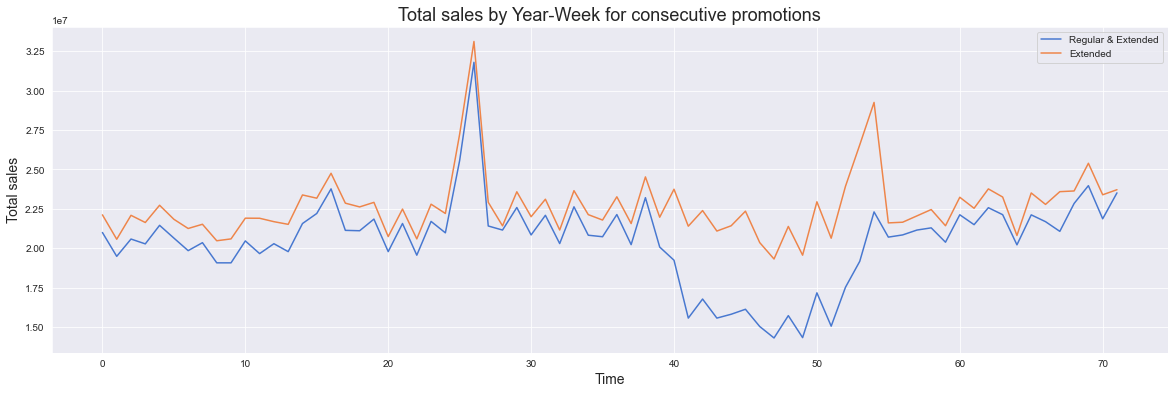

In [66]:
# plots a lineplot
ax = df_consecutive_promotion_sales.plot()

# plots in the same grid
df_no_consecutive_promotion_sales.plot(ax = ax)

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales by Year-Week for consecutive promotions", "Time", "Total sales")

# sets the legend
ax.legend(labels=['Regular & Extended', 'Extended'])

# displays the plot
plt.show()

Observing the results it seems that **stores with higher consecutive promotions don't have higher sales**. 

> #### Thus, our hypothesis is **FALSE**.

**Relevance**

Thinking about the relevance of the variable `promo2` to the ML model, we can say that its relevance is low. Despite the particular decrease in sales during a period, we still need a second opinion that will come from an algorithm that will aid us to decide whether we include `promo2` or not.

### H7. Stores that open on Xmas should have higher sales. 

In [67]:
# gets only the holidays excluding the regular days
df_holidays_only = df4[df4['state_holiday'] != 'regular_day']

# getting the total sales by state holiday
df_total_sales_by_state_holiday = df_holidays_only[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
df_total_sales_by_state_holiday

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305


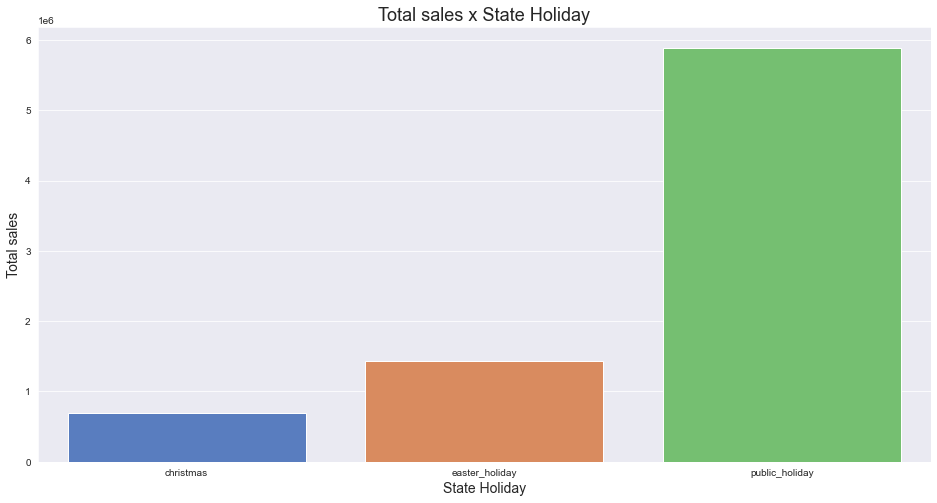

In [68]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='state_holiday', y='sales', data=df_total_sales_by_state_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales x State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

In [69]:
# gets total sales by year by state holiday
df_total_sales_by_year_by_sate_holiday = df_holidays_only[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
df_total_sales_by_year_by_sate_holiday

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


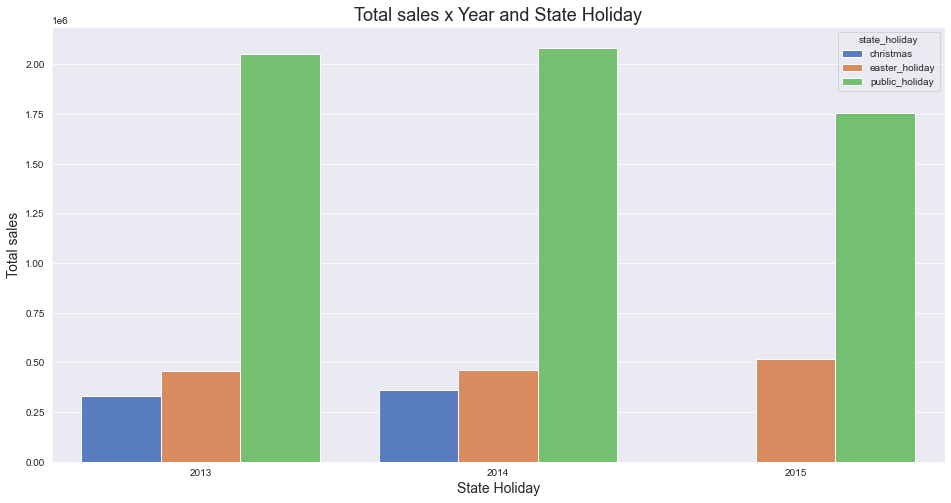

In [70]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='year', y='sales', hue='state_holiday', data=df_total_sales_by_year_by_sate_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year and State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

As observed in the previous results, **stores that open on Xmas don't have higher sales**. 

> #### Thus, our hypothesis is **FALSE**.

One observation that we need to make here is that on year 2015, we still don't have the data from Xmas sales, because the data ends on July 31st, 2015.

In addition, as we have changes in `sales` depending on the type of `state_holiday` and which `year` is, we can consider these variables in our ML model.

### H8. Stores should have higher sales along the years.

In [71]:
# gets the total sales by year
df_total_sales_by_year = df4[['year', 'sales']].groupby('year').sum().reset_index()
df_total_sales_by_year

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


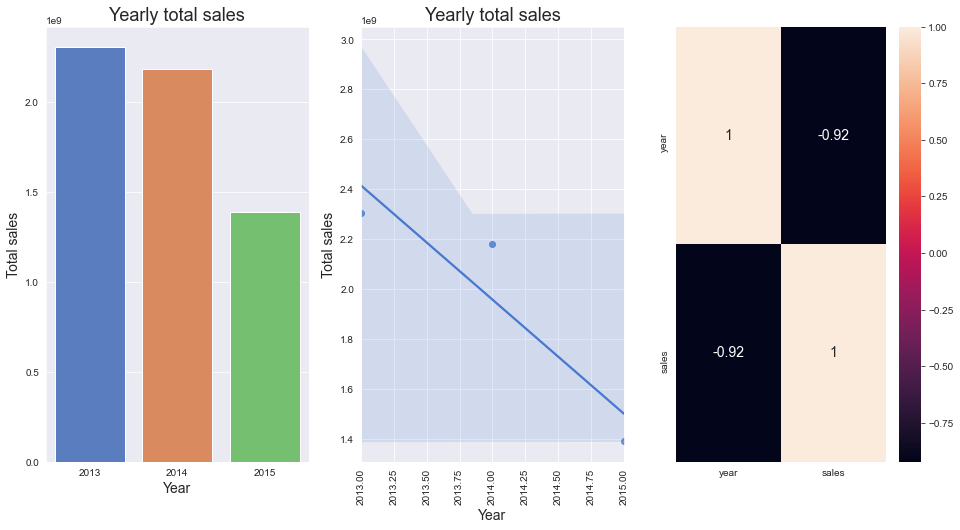

In [72]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by year
plt.subplot(1, 3, 1)
ax = sns.barplot(x='year', y='sales', data=df_total_sales_by_year)

# sets the title and axis labels
set_plots_features(ax, "Yearly total sales", "Year", "Total sales")


# plots a barplot for total sales by year
plt.subplot(1, 3, 2)
ax = sns.regplot(x='year', y='sales', data=df_total_sales_by_year)

# sets the title and axis labels
set_plots_features(ax, "Yearly total sales", "Year", "Total sales")

# rotates xticks labels
plt.xticks(rotation=90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_year.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

As observed in the previous results, stores **don't have higher sales along the years**. In addition, by observing the Pearson correlation coefficient of `-0.92`, we can verify that there is a **strong negative correlation** between `year` and `sales`. Thus, our hypothesis is **FALSE**.

### H9. Stores should have higher sales on the second semester of the year.

In [73]:
# gets the total sales by month
df_total_sales_by_month = df4[['month', 'sales']].groupby('month').sum().reset_index()
df_total_sales_by_month

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


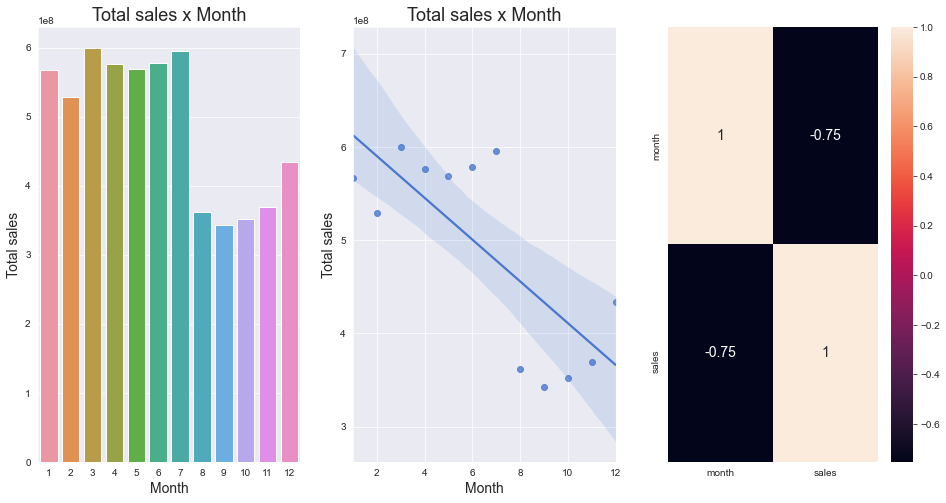

In [74]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by month
plt.subplot(1, 3, 1)
ax = sns.barplot(x='month', y='sales', data=df_total_sales_by_month)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 2)
ax = sns.regplot(x='month', y='sales', data=df_total_sales_by_month)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_month.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

As observed in the previous results, stores **don't have higher sales on the second semester of the year**. In addition, by observing the Pearson correlation coefficient of `-0.75`, we can verify that there is a **strong negative correlation** between `month` and `sales`. 

> #### Thus, our hypothesis is **FALSE**.

### H10. Stores should have higher sales after the 10th day of the month.

In [75]:
# gets the total sales by before and after the 10th day of the month
df_total_sales_by_day = df4[['day', 'sales']].groupby('day').sum().reset_index()

df_total_sales_by_day

,day,sales
0,1,155983560
1,2,233513169
2,3,194582812
3,4,228301010
4,5,212869176
5,6,197094539
6,7,201380487
7,8,189718770
8,9,175922427
9,10,181039363


In [76]:
# classifies which day is before and after the 10th day of the month
df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# gets the total sales by before and after the 10th day of the month
df_total_sales_by_before_after = df4[['before_after', 'sales']].groupby('before_after').sum().reset_index()

df_total_sales_by_before_after

,before_after,sales
0,after_10_days,3902775310
1,before_10_days,1970405313


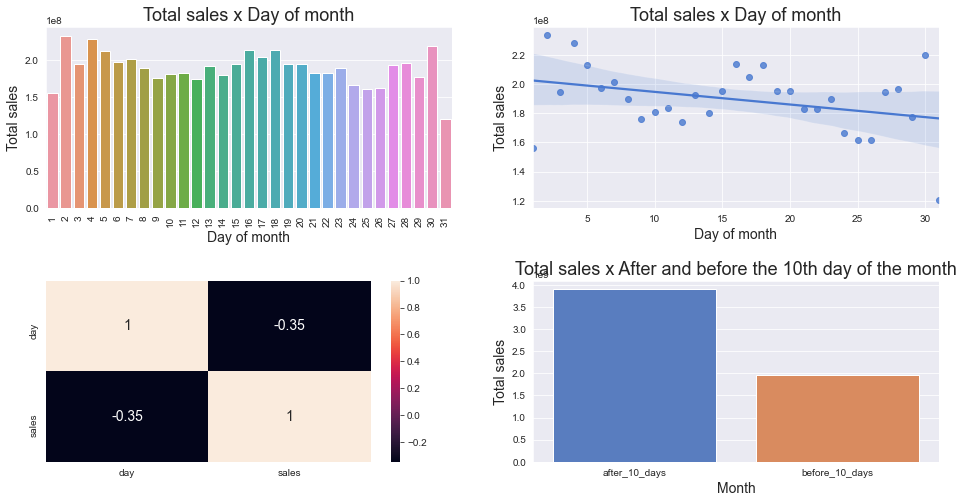

In [77]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day
plt.subplot(2, 2, 1)
ax = sns.barplot(x='day', y='sales', data=df_total_sales_by_day)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")

# rotates the xticks
plt.xticks(rotation=90)

# plots a barplot for total sales by day
plt.subplot(2, 2, 2)
ax = sns.regplot(x='day', y='sales', data=df_total_sales_by_day)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")


# plots a barplot for total sales by day
plt.subplot(2, 2, 3)
sns.heatmap(df_total_sales_by_day.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})


# plots a barplot for total sales by before and after the 10th day of the month
plt.subplot(2, 2, 4)
ax = sns.barplot(x='before_after', y='sales', data=df_total_sales_by_before_after)

# sets the title and axis labels
set_plots_features(ax, "Total sales x After and before the 10th day of the month", "Month", "Total sales")

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As observed in the previous results, stores **have higher sales after the 10th day of the month**. 

> #### Thus, our hypothesis is **TRUE**.

**Correlation**

In addition, checking the Pearson's correlation coefficient, we got a value of `-0.35` which tells us that is a **no so strong correlation** between `day` and `sales`. However, as we have different values for total sales before and after the 10th day of the month, this variable **can be relevant for our ML Model**.

### H11. Stores should have lesser sales on weekends.

In [78]:
# gets the total sales by day_of_week
df_total_sales_by_day_of_week = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
df_total_sales_by_day_of_week

,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


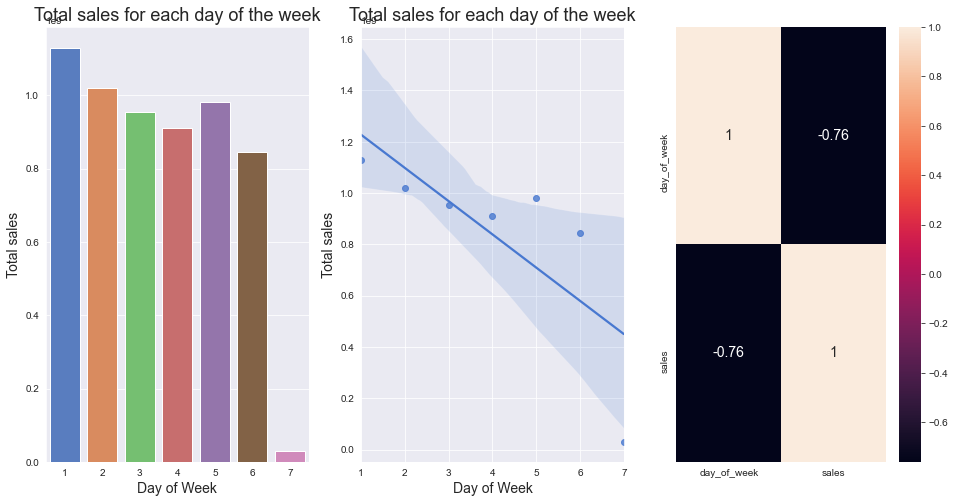

In [79]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 1)
ax = sns.barplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")


# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 2)
ax = sns.regplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_day_of_week.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

**Correlation**

As observed in the previous results, stores **have lesser sales on weekends**. In addition, by observing the Pearson correlation coefficient of `-0.75`, we can verify that there is a **strong negative correlation** between `day_of_week` and `sales`. 

> #### Thus, our hypothesis is **TRUE**.

### H12. Stores should have lesser sales during school holidays.

In [80]:
# gets the total sales by school_holiday
df_total_sales_by_school_holiday = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
df_total_sales_by_school_holiday

,school_holiday,sales
0,0,4696260531
1,1,1176920092


In [81]:
# gets the total sales by month and school_holiday
df_total_sales_by_month_school_holiday = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
df_total_sales_by_month_school_holiday

,month,school_holiday,sales
0,1,0,490739687
1,1,1,75989037
2,2,0,476170426
3,2,1,52563984
4,3,0,529719808
5,3,1,70112098
6,4,0,432131835
7,4,1,143763460
8,5,0,523512599
9,5,1,45735618


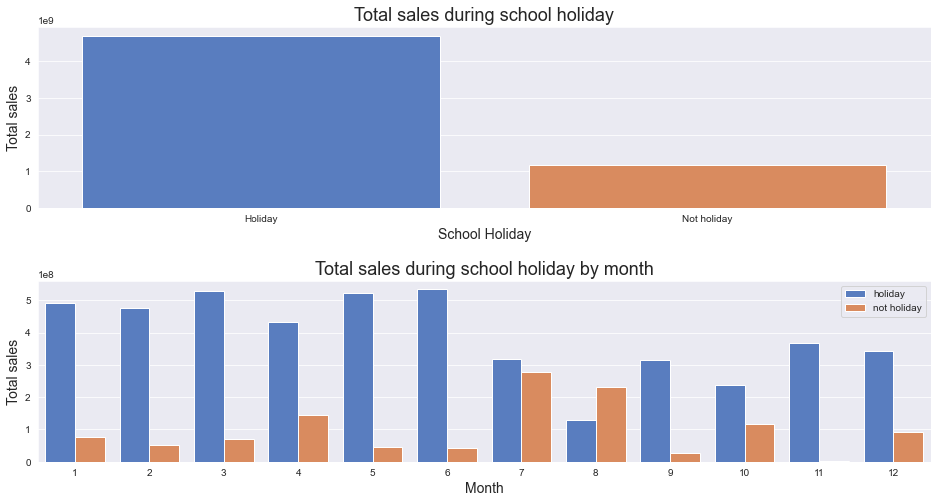

In [82]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by school_holiday
plt.subplot(2, 1, 1)
ax = sns.barplot(x='school_holiday', y='sales', data=df_total_sales_by_school_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales during school holiday", "School Holiday", "Total sales")

# sets xticks labels
ax.set_xticklabels(['Holiday','Not holiday'])

# plots a barplot for total sales by month and school_holiday
plt.subplot(2, 1, 2)
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=df_total_sales_by_month_school_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales during school holiday by month", "Month", "Total sales")

# sets legend
labels = ['holiday','not holiday']
h, _ = ax.get_legend_handles_labels()
ax.legend(h, labels)

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As observed in the previous results, in general, stores **have lesser sales during school holidays, except on months of July and August**. 

> #### Thus, our hypothesis is **TRUE**.

### 4.2.1. Hypotheses summary

In [86]:
tab = [
    ['Hypothesis','Conclusion','Relavance to ML model'],
    ['H1','False','Low'],
    ['H2','False','Medium'],
    ['H3','False','Medium'],
    ['H4','False','Low'],
    ['H5','--','--'],
    ['H6','False','Low'],
    ['H7','False','Medium'],
    ['H8','False','High'],
    ['H9','False','High'],
    ['H10','True','High'],
    ['H11','True','High'],
    ['H12','True','Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relavance to ML model
------------  ------------  -----------------------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            --            --
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

In [87]:
# checks the numerical attributes dataset
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


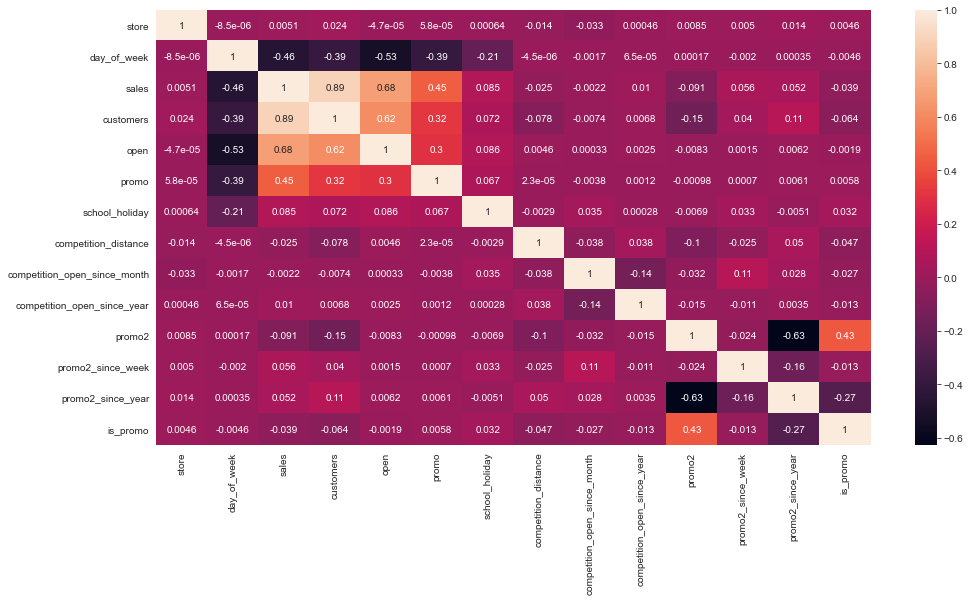

In [88]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

### 4.3.2 Categorical Attributes
To make the correlation between two categorical variables, we'll use the [Cramér V method](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

In [89]:
# gets the categorical variables from the dataset
df_cat_vars = df4.select_dtypes(include='object')
df_cat_vars.head()

,state_holiday,store_type,assortment,year_week,before_after
0,regular_day,c,basic,2015-30,after_10_days
1,regular_day,a,basic,2015-30,after_10_days
2,regular_day,a,basic,2015-30,after_10_days
3,regular_day,c,extended,2015-30,after_10_days
4,regular_day,a,basic,2015-30,after_10_days


In [90]:
# builds the contigency matrix (or confusion matrix) 
confusion_matrix = pd.crosstab(df_cat_vars['state_holiday'], df_cat_vars['store_type']).values
confusion_matrix

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

#### 4.3.2.1 Manually calculating Cramér V using [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

In [91]:
from scipy.stats import chi2_contingency

In [92]:
# getting the chi-squared
chi2 = chi2_contingency(confusion_matrix)[0]
chi2

12792.159524019908

In [93]:
# getting the sum of all values in the matrix
n = confusion_matrix.sum()
n

844338

In [94]:
# getting the rows, cols
r, k = confusion_matrix.shape

print(r, k)

4 4


From [wikipedia](https://en.wikipedia.org/wiki/Cram%C3%A9r's_V).

Cramér's V is computed by taking the square root of the chi-squared statistic divided by the sample size and the minimum dimension minus 1:

### $V = \sqrt{\frac{\varphi^2}{\min(k - 1,r-1)}} = \sqrt{ \frac{\chi^2/n}{\min(k - 1,r-1)}}$

where:
* $\varphi$ is the phi coefficient.
* $\chi^2$ is derived from Pearson's chi-squared test
* $n$ is the grand total of observations and
* $k$ being  the number of columns.
* $r$ being  the number of rows.

**Bias correction**

Cramér's V can be a heavily biased estimator of its population counterpart and will tend to overestimate the strength of association. A bias correction, using the above notation, is given by:

$\tilde V = \sqrt{\frac{\tilde\varphi^2}{\min(\tilde k - 1,\tilde r - 1)}} $&nbsp;

where

$ \tilde\varphi^2 = \max\left(0,\varphi^2 - \frac{(k-1)(r-1)}{n-1}\right) $&nbsp;

and

$ \tilde k = k - \frac{(k-1)^2}{n-1} $&nbsp;

$ \tilde r = r - \frac{(r-1)^2}{n-1} $&nbsp;

Then $\tilde V$ estimates the same population quantity as Cramér's V but with typically much smaller mean squared error. The rationale for the correction is that under independence, $E[\varphi^2]=\frac{(k-1)(r-1)}{n-1}$.

The range of Cramér V is [0 to 1], so we don't have negative correlation. Thus, the closer to zero, the lesser is the correlation and the closer to 1, the higher is the correlation.

In [95]:
# calculates Cramér V
cramer_v = np.sqrt((chi2/n) / min(k-1, r-1))
cramer_v

0.07106457093267678

#### 4.3.2.2 Using the defined `cramer_v` function to make the calculations

In [98]:
# makes all the possible combinations between categorical variables
a1 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['state_holiday'])
a2 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['store_type'])
a3 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['assortment'])

a4 = cramer_v(df_cat_vars['store_type'], df_cat_vars['state_holiday'])
a5 = cramer_v(df_cat_vars['store_type'], df_cat_vars['store_type'])
a6 = cramer_v(df_cat_vars['store_type'], df_cat_vars['assortment'])

a7 = cramer_v(df_cat_vars['assortment'], df_cat_vars['state_holiday'])
a8 = cramer_v(df_cat_vars['assortment'], df_cat_vars['store_type'])
a9 = cramer_v(df_cat_vars['assortment'], df_cat_vars['assortment'])

# builds the dataset to make the correlations
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],
             })

# sets index equal to columns
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


#### 4.3.2.3 Plotting the correlations

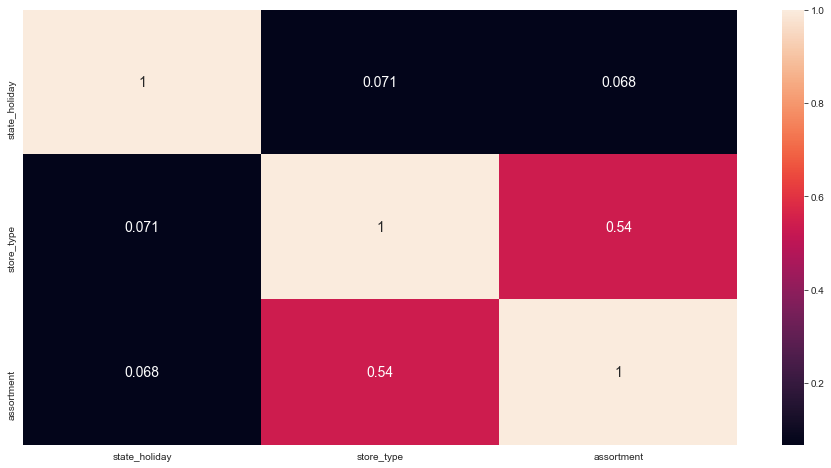

In [99]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# displays plot
plt.show()

As observed in the results, the correlation coefficient between `store_type` and `assortment` is `0.54` which is a medium correlation and makes sense, as the bigger the store, the higher is the assortment of its products.

# 5.0 DATA PREPARATION

### 5.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df4`. So we don't have to run everything from the start. We can start from here.

In [100]:
# copies df4 to df5
df5 = df4.copy()

In [101]:
# checks de dataset
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,after_10_days
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,after_10_days
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,after_10_days
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,after_10_days
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,after_10_days


## 5.1 Normalization

We need to check the variables distributions. So, we check the distributions from section **4.1.2 Numerical variable**.

![](../img/412_numerical_variables_hist.png)

As we can observe, there is no variable presenting a normal distribution, note even nearly normal. So, it is preferred to leave as it is than to risk a erroneous normalization.

## 5.2 Rescaling

First we need to identify which variable we need to apply the rescaling.

In [102]:
# selects only numerical data types variables
df_numerical_vars = df5.select_dtypes(include=['int64','float64'])
df_numerical_vars.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


#### Using sklearn.preprocessing.RobustScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html?highlight=robustscaler#sklearn.preprocessing.RobustScaler

#### Using sklearn.preprocessing.MinMaxScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=sklearn%20preprocessing%20minmaxscaler

In [103]:
# instantiates the classes
rs = RobustScaler()
mms = MinMaxScaler()

### 5.2.1 Rescaling `competition_distance`

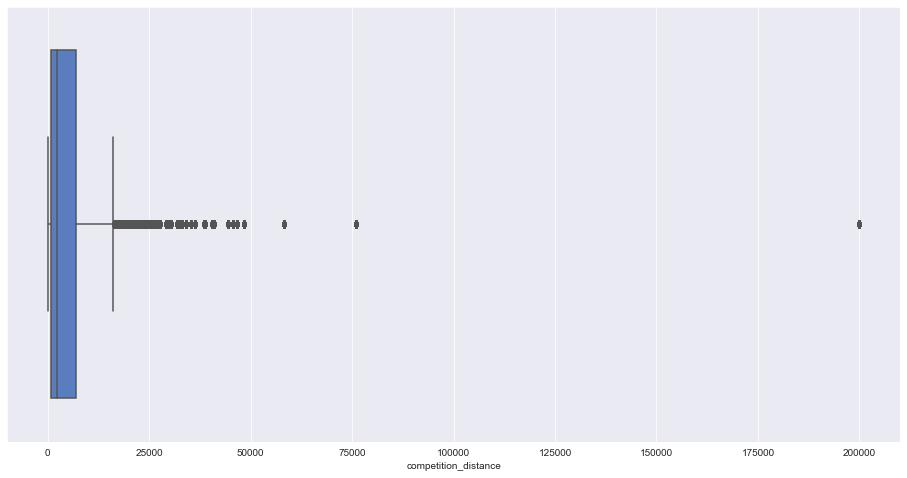

In [104]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['competition_distance'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers.

In [105]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])

# saves the rescaling
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/competition_distance_scaler.pkl'

In [ ]:
df5[['competition_distance']]

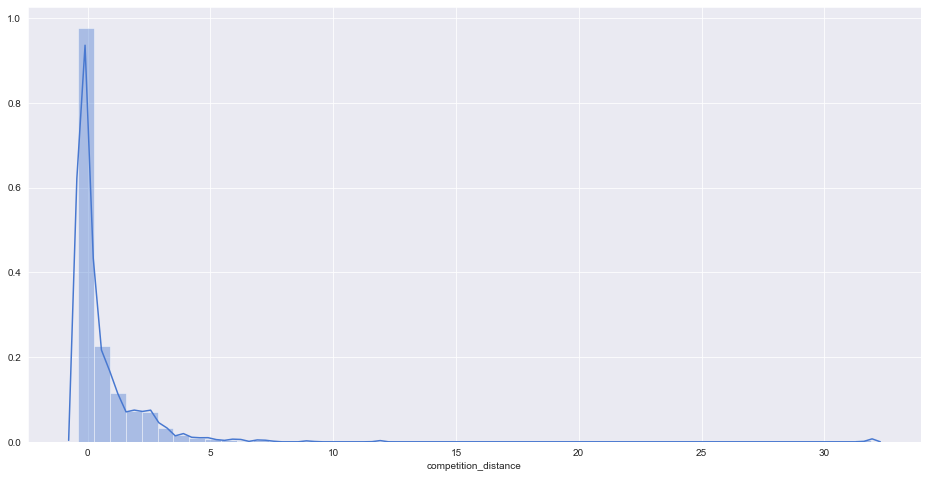

In [106]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.distplot(df5['competition_distance'])

# display the plot
plt.show()

### 5.2.2 Rescaling `competition_time_month`

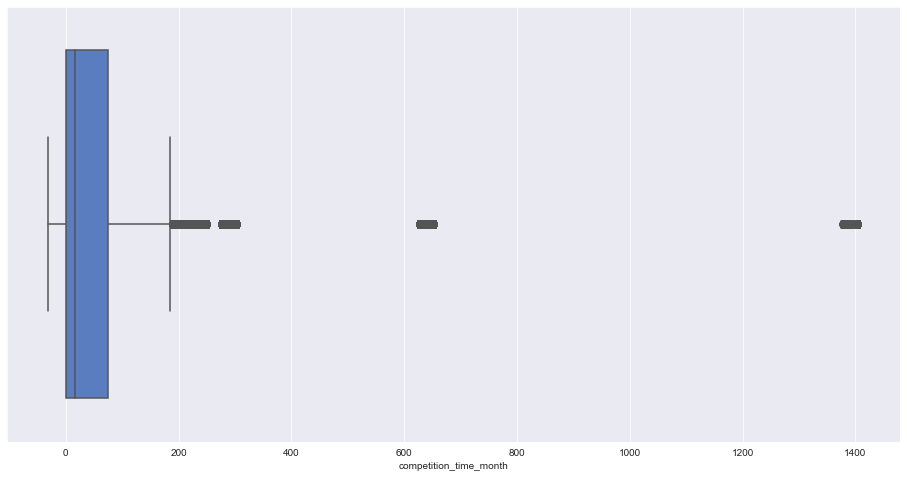

In [107]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['competition_time_month'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers.

In [108]:
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])

# saves the rescaling
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/competition_time_month_scaler.pkl'

In [109]:
# checks the operation
df5[['competition_time_month']]

,competition_time_month
0,0.918919
1,1.054054
2,1.202703
3,0.743243
4,-0.162162
...,...
1016776,0.824324
1016827,1.959459
1016863,-0.216216
1017042,-0.216216


### 5.2.3 Rescaling `promo_time_week`

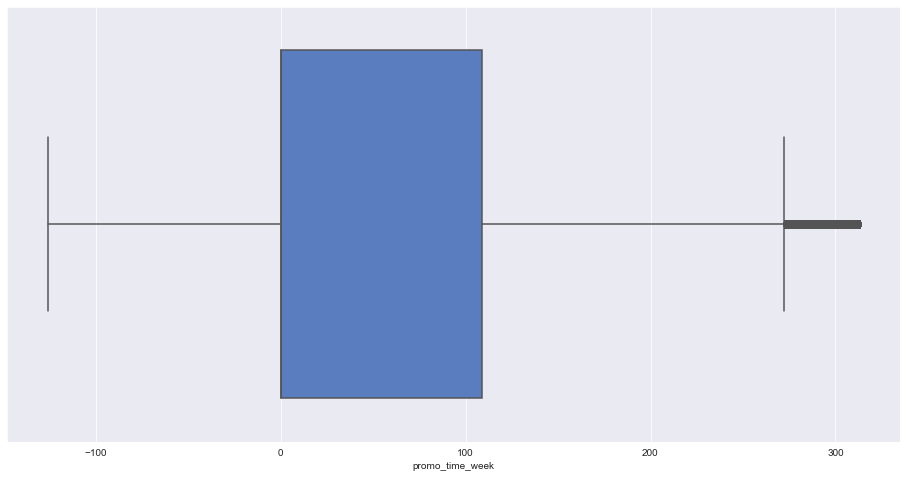

In [110]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['promo_time_week'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers. However, they are not that far from the superior whisker. So we can take a chance to use the Min-Max Scaler.

In [111]:
# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

# saves the rescaling
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/promo_time_week_scaler.pkl'

In [112]:
# checks the operations
df5[['promo_time_week']]

,promo_time_week
0,0.287016
1,0.922551
2,0.801822
3,0.287016
4,0.287016
...,...
1016776,0.287016
1016827,0.287016
1016863,0.300683
1017042,0.287016


In [113]:
# year
df5['year'] = mms.fit_transform(df5[['year']])

# saves the rescaling
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/year_scaler.pkl'

## 5.3 Transformation

### 5.3.1 Encoding

#### 5.3.1.1 One Hot Encoding for `state_holiday`

In [114]:
# state_holiday
# One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [115]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1


#### 5.3.1.2 Label Encoding for `store_type`

In [116]:
# instantiates the class
le = LabelEncoder()

In [117]:
# store_type
# Label Encoding - as we don't know if there is an order
df5['store_type'] = le.fit_transform(df5['store_type'])

# saves the encoder
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/store_type_scaler.pkl'

In [118]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1


#### 5.3.1.3 Label Encoding for `assortment`

In [119]:
# assortment
# Ordinal Encoding - as there is an order

# explicitly dictates the encoding codes
assortment_dict = {'basic':1,
                   'extra': 2,
                   'extended': 3
                  }

# maps the names
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [120]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1


### 5.3.2 Target Variable Transformation

In [121]:
# applies the logarithm 
df5['sales'] = np.log1p(df5['sales'])

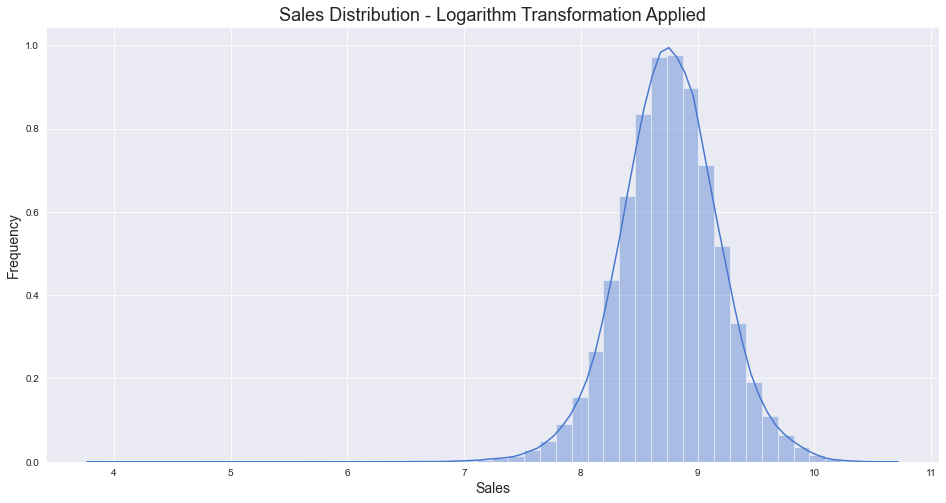

In [122]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.distplot(df5['sales'])

# sets the plot features
set_plots_features(ax, "Sales Distribution - Logarithm Transformation Applied", "Sales", "Frequency")

# display the plot
plt.show()

### 5.3.2 Nature Transformation

In [123]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

In [124]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 5.4 Exporting dataset
Here we make a project checkpoint so we don't have to run all cells to reach the dataset current state.

In [125]:
# sets compression method
compression_opts = dict(method='zip', archive_name='store_data_df5.csv')  

# exports the dataset to a CSV file
df5.to_csv('../data/store_data_df5.zip', index=False, compression=compression_opts)

# 6.0 FEATURE SELECTION

### 6.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df5`. So we don't have to run everything from the start. We can start from here.

In [126]:
# copies df5 to df6
df6 = df5.copy()

In [4]:
# loads saved data
df6 = pd.read_csv('../data/store_data_df5.csv')

In [127]:
# converts do datetime64
df6['date'] = pd.to_datetime(df6['date'])

### 6.0.2 Dropping columns
As we have derived several variables, we need to drop the original variables.

In [128]:
# sets which cols need to be dropped
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# drops the given columns
df6 = df6.drop(cols_drop, axis=1)

In [129]:
# checks the operation
df6

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,after_10_days,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,0.824324,0.287016,before_10_days,0,0,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1.959459,0.287016,before_10_days,0,0,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,-0.216216,0.300683,before_10_days,0,0,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,-0.216216,0.287016,before_10_days,0,0,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709


## 6.1 Split dataframe into training and test datasets

To avoid overfitting in our model, we'll separate de last 6 weeks of our dataset for test and all the previous data for training.

In [130]:
# gets the first sales dates for each store
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [131]:
# gets the last sales dates for each store
df6[['store','date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [132]:
# gets the date before the last 6 weeks of sales for each store
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [133]:
# creates the training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# creates the test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

# checking the operations
print('Traning Min Date: {}'.format(X_train['date'].min()))
print('Traning Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as fetaure selector

In [134]:
# define traning and test data for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

In [135]:
# define RandomForestRegressor
# uses all cores from CPU (n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1)

**Disclaimer:** as the Boruta method takes very long time to run (~4h to 6h), I got the final features from the course video. Thus, the code that makes the calculation was commented.

In [ ]:
# define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1 Best features from Boruta

In [ ]:
# # gets the ranked list of features
# cols_selected = boruta.support_.tolist()

# # gets the dataset w/o 'date' and 'sales'
# X_train_feature_selection = X_train.drop(['date', 'sales'], axis=1)

# # get best features (only columns) as a list
# cols_selected_boruta = X_train_feature_selection.iloc[:, cols_selected].columns.to_list()

In [ ]:
# # gets the columns that weren't selected by Boruta by comparison
# cols_no_selected_boruta = list(np.setdiff1d(X_train_feature_selection, cols_selected_boruta))
# cols_not_selected_boruta

Comparing the columns between the ones that we outlined in the conclusion from our hypothesis and the ones that Boruta suggested, we can see some differences.

However, this is not a problem, **since we are working in an iterative process (CRISP-DS)**. We can first test the model using only the features that Boruta suggested, then include the one by one from our hypothesis and test to see what happens.

We'll include: `month_sin`, `week_of_year_sin`. 

## 6.3 Manual feature selection

In [136]:
# bypasses the Boruta lenghty calculations
cols_selected_boruta = ['store', 'promo', 'store_type',
                       'assortment','competition_distance', 'competition_open_since_month',
                       'competition_open_since_year','promo2', 'promo2_since_week',
                       'promo2_since_year','competition_time_month', 'promo_time_week',
                       'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
                       'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']

In [137]:
# includes the columns
feat_to_add = ['date','sales']

# final selected features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 6.4 Exporting dataset
Here we make a project checkpoint so we don't have to run all cells to reach the dataset current state.

In [ ]:
# sets compression method
compression_opts = dict(method='zip', archive_name='store_data_df6.csv')  

# exports the dataset to a CSV file
df6.to_csv('../data/store_data_df6.zip', index=False, compression=compression_opts)

# 7.0 MACHINE LEARNING MODELING

### 7.0.1 Loading data

In [ ]:
# loads the dataset
df7 = pd.read_csv('../data/store_data_df6.csv', low_memory=False)

In [ ]:
# checks the dataset
df7

### 7.0.2 Separating the data

In [138]:
# selects only the cols that where selected by Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [139]:
# creates dataset for test
x_test_copy = x_test.copy()
x_test_copy['sales'] = Y_test.copy()

## 7.1 Average model

#### Using sklearn.metrics
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [140]:
# prediction
# gets the mean sales by store
df_mean_sales_by_store = x_test_copy[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# merges the datasets
x_test_copy = pd.merge(x_test_copy, df_mean_sales_by_store, how='left', on='store')

# estimates : baseline
yhat_baseline = x_test_copy['predictions']


# performance
# calculates the performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression model

#### Using sklearn.linear_model.LinearRegression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

In [141]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Observing the results, the RMSE from the Linear Regression model (`2671.049215`) is higher than the RMS from Average model (`1835.135542`). Thus, the performance of the Linear Regression model is worse than the Average model. In addition, this tells us that the complexity of the relation between the variables is higher than linear. There is a non-linear relation.

## 7.3 Linear Regression Regularized model - Lasso

#### Using sklearn.linear_model.Lasso
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

The `alpha=0.01` is a parameter for the `Lasso` is used to balance the weights between the variables.

In [142]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.4 Random Forest Regressor

#### Using sklearn.ensemble.RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [67]:
# model
# 100 trees
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.010019,0.099833,1010.051385


## 7.5 XGBoost Regressor

1. `brew install libomp`

2. `pip install xgboost`

https://www.datacamp.com/community/tutorials/xgboost-in-python

In [68]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', # we're solving a regression problem
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10,  # max depth of the tree
                             subsample=0.7, # percentage os variables to be selected
                             colsample_bytree=0.9).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.759428,0.949487,7331.077173


## 7.6 Comparing Models' Performance

In [69]:
# creates a DataFrame to easily compare models' performance
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.010019,0.099833,1010.051385
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.759428,0.949487,7331.077173


 As observed in the results, the **Random Forest Regressor** had the least RMSE (`1010.322344`). However, this doesn't mean that the Random Forest is the final model that we're going to pick for our predictions, because we need to make **cross validation tests** for each model to check their behavior in different data and then pick the right model.

## 7.7 Cross Validation

### Dataset slicing for Time Series

![](../img/77_Cross_Validation.png)

In [70]:
# Time Series Data Preparation
# gets the final set of columns
x_training = X_train[cols_selected_boruta_full]

### 7.7.1 Cross validation for Linear Regression Model

In [71]:
# makes the cross validation
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

# checks the results
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37


### 7.7.2 Cross validation for Lasso Model

In [72]:
# makes the cross validation
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)

# checks the results
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


### 7.7.3 Cross validation for Random Forest Regressor model

In [73]:
# makes the cross validation
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)

# checks the results
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.5 +- 218.9,0.12 +- 0.02,1256.17 +- 319.33


### 7.7.4 Cross validation for XGBoost Regressor model

In [74]:
# makes the cross validation
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)

# checks the results
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7048.93 +- 588.52,0.95 +- 0.0,7714.89 +- 689.29


### 7.7.5 Single Performance

In [75]:
# creates a DataFrame to easily compare models' performance
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.010019,0.099833,1010.051385
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.759428,0.949487,7331.077173


### 7.7.6 Real Performance - Cross Validation

In [76]:
# creates a DataFrame to easily compare models' performance
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.5 +- 218.9,0.12 +- 0.02,1256.17 +- 319.33
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37
0,Linear Regression - Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26
0,XGBoost Regressor,7048.93 +- 588.52,0.95 +- 0.0,7714.89 +- 689.29


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [32]:
# creates the dict
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

# defines the maximum evaluations
MAX_EVAL = 10

In [ ]:
# creates empty DataFrame to store the final results
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # randomly chooses values for parameters
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', # we're solving a regression problem
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'],  # max depth of the tree
                                 subsample=hp['subsample'], # percentage os variables to be selected
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight']).fit(x_train, Y_train)

    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result

## 8.2 Final Model

In [146]:
# creates the dict of final optimized params
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [147]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', # we're solving a regression problem
                            n_estimators=param_tuned['n_estimators'], 
                            eta=param_tuned['eta'], 
                            max_depth=param_tuned['max_depth'],  # max depth of the tree
                            subsample=param_tuned['subsample'], # percentage os variables to be selected
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_tuned_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))

xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.744651,0.115106,1099.467978


## 8.3 Saving the Model

In [ ]:
# saves the model
pickle.dump(model_xgb_tuned, open('../model/model_rossmann.pkl', 'wb'))

# 9.0 ERROR TRANSLATION AND INTERPRETATION

### 9.0.1 Project checkpoint

In [148]:
df9 = X_test[cols_selected_boruta_full]

### 9.0.2 Rescaling back
As we have applied variable transformation, we need to transform them back to their original scale.

In [149]:
# rescales
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

In [150]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.018794787955056767

## 9.1 Business Performance

In [151]:
# gets total sales predictions by store
df_predictions_by_store = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df_predictions_MAE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df_predictions_MAPE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merges DataFrames
df_MAE_MAPE = pd.merge(df_predictions_MAE, df_predictions_MAPE, how='inner', on='store')
df_predictions_MAE_MAPE = pd.merge(df_predictions_by_store, df_MAE_MAPE, how='inner', on='store')

# creates scenarios
df_predictions_MAE_MAPE['worst_scenario'] = df_predictions_MAE_MAPE['predictions'] - df_predictions_MAE_MAPE['MAE']
df_predictions_MAE_MAPE['best_scenario'] = df_predictions_MAE_MAPE['predictions'] + df_predictions_MAE_MAPE['MAE']

# organizes columns
df_predictions_MAE_MAPE = df_predictions_MAE_MAPE[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [84]:
df_predictions_MAE_MAPE.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108633.492188,105215.924830,112051.059545,3417.567357,0.611000
908,909,224070.812500,216207.786664,231933.838336,7863.025836,0.519385
901,902,201216.015625,199775.258261,202656.772989,1440.757364,0.360238
169,170,204236.187500,202821.217457,205651.157543,1414.970043,0.349291
875,876,193354.906250,189231.879522,197477.932978,4123.026728,0.332035


As observed in the results, we need to report to the business that there are stores that are more difficult to make the predictions.

Some strategies that may solve this challenge in the next CRISP iteration could be taking a closer look on the variables, try other methods, try other techniques.

### 9.1.1 Stores Analysis

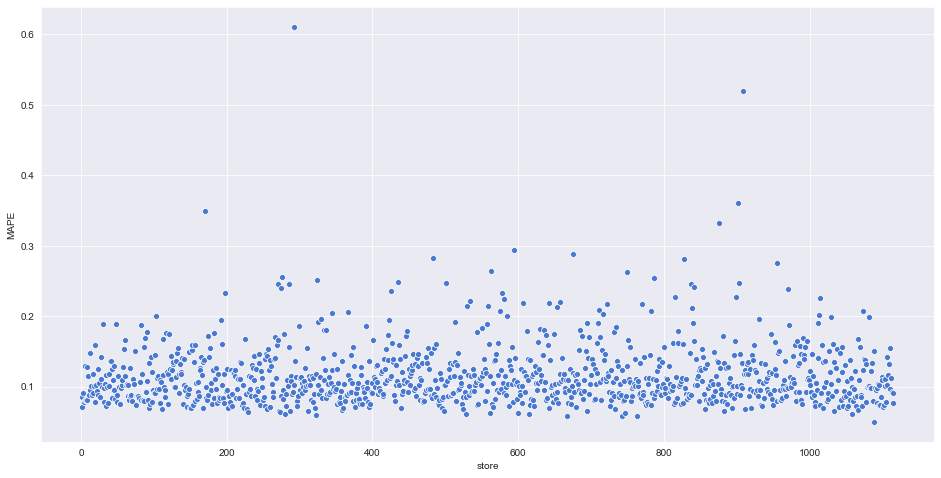

In [154]:
# create Axis
fig, ax = plt.subplots()

# set figure size
ax.figure.set_size_inches(16, 8)

# plots the data
ax = sns.scatterplot(x='store', y='MAPE', data=df_predictions_MAE_MAPE)

# displays the plot
plt.show()

Observing the results, we can see that there are stores that have higher MAPE values. So, these are the stores that presents challeging predictions.

In [155]:
# checks the operations
df_predictions_MAE_MAPE.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
342,343,267938.656250,267098.345241,268778.967259,840.311009,0.104706
467,468,242022.484375,241189.301243,242855.667507,833.183132,0.133929
187,188,185338.781250,184608.583800,186068.978700,730.197450,0.117608
934,935,222856.437500,222443.429727,223269.445273,413.007773,0.072092
375,376,288860.656250,288255.625937,289465.686563,605.030313,0.071256


## 9.2 Total Performance

In [153]:
# gets the total sales by scenario
df_scenario_values = df_predictions_MAE_MAPE[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})

# formats the values to monetary
df_scenario_values['Values'] = df_scenario_values['Values'].map('US$ {:,.2f}'.format)

df_scenario_values

,Scenario,Values
0,predictions,"US$ 286,559,476.27"
1,worst_scenario,"US$ 285,703,608.10"
2,best_scenario,"US$ 287,415,344.43"


## 9.3 Machine Learning Performance

In [156]:
# gets the error
df9['error'] = df9['sales'] - df9['predictions']

# gets the error rate
df9['error_rate'] = df9['predictions'] / df9['sales']

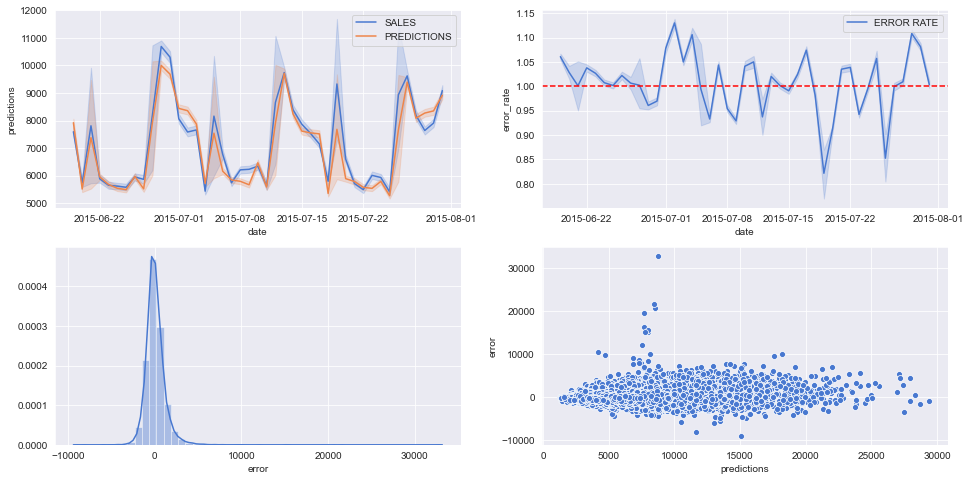

In [157]:
# create Axis
fig, ax = plt.subplots()

# set figure size
ax.figure.set_size_inches(16, 8)

# plots the data
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')


# plots the data
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--', color='r')


# PLOTS FOR RESIDUAL ANALYSIS
# plots the data
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])


# plots the data
plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])


# displays the plot
plt.show()

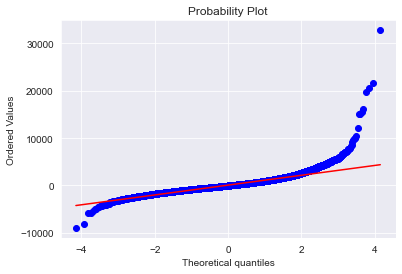

In [158]:
from scipy import stats

stats.probplot(df9['error'], plot=plt);

Observing the results, we can see that:
- By observing the **first and second line plots**, we can see that the predictions or our model is pretty close to the real value for `sales`. On the other hand, the error rate has some variance.

- By observing the **histogram**, the error distribution almost follows a normal distribution. 

- By observing the **scatterplot** for the errors, the points seems well fit in a horizontal tube which means that there's a few variation in the error. If the points formed any other shape (e.g opening/closing cone or an arch), this would mean that the errors follows a trend and we would need to review our model.

# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [34]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/Users/brunokatekawa/Desktop/Data Science/DataScienceProducao/Curso_DS_Prod/'
        # loads the rescaling
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        
        # loads the encoder
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

        
    def data_cleaning(self, df1):

        ## 1.1. Renaming columns
        # stores the old column names
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 
                    'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        # snake_case
        snakecase = lambda x: inflection.underscore(x)

        # creates new columns from old columns in snakecase 
        cols_new = list(map(snakecase, cols_old))

        # renames the old columns
        df1.columns = cols_new


        ## 1.3.  Checking data types
        # transforms 'date' column to datetime type
        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5.  Filling out the NaN values
        ### 1.5.1 Filling the competition data

        # competition_distance
        # let's assume that the distance from competitors is so long that there are no competitors
        # applies for each column record: competition_distance
        #     assign 200000.0 if record == NaN ; assign its current value if record != NaN
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        # let's assume that the opening date is the store sales date: date
        # axis=1 -> apply in the row along the columns, because we have more than one column in the expression
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        ### 1.5.2 Filling the promotion data
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        # creates a dictionary that will help in mapping
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        # fills in the NaN with zeroes
        df1['promo_interval'].fillna(0, inplace=True)

        # creates the 'month_map' column as the month mapping of the 'date' column
        df1['month_map'] = df1['date'].dt.month.map(month_map)


        # make a split in 'promo_interval' column and creates a list containing the values
        # check if the value of 'month_map' is within that list
        # creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6.  Changing data types
        # transforms competition data to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # transforms promotion data to int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    
    def feature_engineering(self, df2):
        # 2.0 FEATURE ENGINEERING
        ## 2.4 Feature engineering - de facto

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        # creates a new datetime column 'competition_since' which is a compound of two columns
        # we are specifying that it will always have the 1st day of the month
        df2['competition_since'] = df2.apply(lambda x: 
                                             datetime.datetime(year=x['competition_open_since_year'], 
                                                                         month=x['competition_open_since_month'], 
                                                                         day=1), 
                                             axis=1)


        # How many months has passed since the competition store opened?
        # gets the difference between columns and divides it by 30 to make the monthly granularity
        #     then we get the days as int type
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)


        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

        # converts values from 'promo_since' to datetime considering 7 days
        df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                                 datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        # How many weeks has passed since the promotion started?
        # OR for how long (in weeks) the promotion is active?
        # gets the difference between columns and divides it by 7 to make the weekly granularity
        #     then we get the days as int type
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)


        # assortment
        # replaces the values to make easier to understand them
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        # replaces the values to make easier to understand them
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


        # 3.0 VARIABLE FILTERING
        ## 3.1 Row filtering
        # gets only the rows for open stores
        df2 = df2[df2['open'] != 0]
        
        ## 3.2 Column filtering
        # drops the columns
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2


    def data_preparation(self, df5):
        
        ## 5.2 Rescaling
        ### 5.2.1 Rescaling competition_distance
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']])


        ### 5.2.2 Rescaling competition_time_month
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']])

        
        ### 5.2.3 Rescaling promo_time_week
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']])

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']])
        
        
        ## 5.3 Transformation
        ### 5.3.1 Encoding
        #### 5.3.1.1 One Hot Encoding for state_holiday

        # state_holiday
        # One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])


        #### 5.3.1.2 Label Encoding for store_type
        # store_type
        # Label Encoding - as we don't know if there is an order
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        #### 5.3.1.3 Label Encoding for assortment
        # assortment
        # Ordinal Encoding - as there is an order

        # explicitly dictates the encoding codes
        assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}

        # maps the names
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.2 Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))
        
        cols_selected = ['store', 'promo', 'store_type',
                       'assortment','competition_distance', 'competition_open_since_month',
                       'competition_open_since_year','promo2', 'promo2_since_week',
                       'promo2_since_year','competition_time_month', 'promo_time_week',
                       'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
                       'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #predicts
        pred = model.predict(test_data)
        
        # joins pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [35]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loads model
model = pickle.load(open('/Users/brunokatekawa/Desktop/Data Science/DataScienceProducao/Curso_DS_Prod/model/model_rossmann.pkl', 'rb'))

# initializes API
app = Flask(__name__)

# creates the endpoint
@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predcit():
    # gets json that comes from API
    test_json = request.get_json()
    
    # checks if json exists
    if test_json:   
        # unique example
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
            
        #multiple examples
        else:
            print('NAO passou pelo unique example')
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        
        # instantiates Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

# checks if there is main in the class
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [11]:
# loads test dataset
df10 = pd.read_csv('../data/test.csv')

In [12]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# selects store for prediction
df_test = df_test[df_test['Store'].isin([20, 10, 27])]

# drops closed days and Id column
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [13]:
# converts DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [14]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [15]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [16]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']))

Store Number 10 will sell R$218,421.60 in the next 6 weeks
Store Number 20 will sell R$306,757.39 in the next 6 weeks
Store Number 27 will sell R$258,108.48 in the next 6 weeks
